In [1]:
# import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import difflib

# for fuzzy matching variable names for various NOAA data sets
from fuzzywuzzy import fuzz
import re 

# To view dictionaries in a nicer format!
import pprint

# For datetime
from datetime import datetime

# To calculate ECDF
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline 

# libraries for geographic visualization 
# import OSMPythonTools as osm
# from mpl_toolkits.basemap import Basemap
# _geoslib module missing for the mpl_toolkits.basemap import

# Cite when you use cartopy 
import cartopy 

ModuleNotFoundError: No module named 'OSMPythonTools'

In [4]:
from IPython.display import display

pd.options.display.max_columns = None

In [5]:
print(os.getcwd())

C:\Users\wlang\Documents\UW files\Research\Great Lakes Data


# NOAA Data

First, we will read in and clean NOAA data for the western basin of Lake Erie.

## Concatenate Data Sets

In [157]:
# Compare NOAA data sets - do all the different sets have the same format?
# First look at one station

WE02_2014 = pd.read_csv('NOAA Western Lake Erie\WE02\WE02_2014_annual_summary.csv', na_values='NAN', skiprows=[1, 2])
WE02_2015 = pd.read_csv('NOAA Western Lake Erie\WE02\WE02_2015_annual_summary.csv', na_values='NAN', skiprows=[1, 2])

In [20]:
print(WE02_2014.shape, WE02_2015.shape)
# Different shapes

print('Intersection of variables: ', list(set(list(WE02_2014.columns)).intersection(list(WE02_2015.columns))))

print('Variables in 2014 not in 2015:')
print(np.setdiff1d(list(WE02_2014.columns), list(WE02_2015.columns)))

print('Variables in 2015 not in 2014:')
print(np.setdiff1d(list(WE02_2015.columns), list(WE02_2014.columns)))

(3921, 30) (12267, 45)
Intersection of variables:  ['organic_dissolved_oxygen_saturation', 'depth_c6', 'phycocyanin_c6', 'organic_dissolved_oxygen', 'phycocyanin', 'phycoerythrin_c6', 'chlorophylla', 'depth', 'chlorophylla_c6', 'colored_dissolved_organic_matter_c6', 'water_temperature', 'flourescent_dissolved_organic_matter', 'specific_conductivity', 'turbidity_c6', 'timestamp', 'turbidity']


It seems that the NOAA data sets don't have a set format/convention for variable naming nor do they have a uniform set of variables. I will stil combine the data sets for the sake of data visualization - it's easier to have all the data within one set. 

Some variable names vary due to small details such as capitalization ex. ph, pH. To (hopefully) merge these columns together when concatenating the data sets, I will set all column names to lowercase.

Moored buoy data sets have coordinates stated in a separate data set! I will add latitude and longitude to the moored buoys' data sets first.

In [4]:
## read in all data sets
# also add coordinate data to the buoy data! Format in terms of longitude, latitude
# Coordinate files for moored buoys should just be ONE set of coordinates 

# Function taken from stack overflow
def is_unique(coords):
    coords_np = coords.to_numpy() 
    return (coords_np[0] == coords_np).all()

# Check if there are multiple coordinates for moored buoys. If there are, check if the coordinates differ
def get_coords(coord_df):
    if coord_df.shape[0] == 1:
        return(coord_df)
    else:
        if is_unique(coord_df):
            coord_df = coord_df.iloc[[0],]
            return(coord_df)
        else: 
            raise Exception('There should only be one unique set of coordinates for moored buoys. There are {} sets of coordinates'.
                            format(coord_df.drop_duplicates().shape[0]))

In [5]:
noaa_folder = 'NOAA Western Lake Erie'
noaa_locs = ['WE02', 'WE04', 'WE08', 'WE13', 'Small_boat_2012_2018', 'Small_boat_2019']

# Dictionary to store lake data
NOAA_sets = {} 

# Dictionary to store lake coordinates
NOAA_coords = {}

# Dictionary to store measurement unit details and apparatuses
dataset_measure_details = {}

# Read in files 
for location in noaa_locs: 
    
    noaa_dir = os.path.join(os.getcwd(), noaa_folder, location)
    
    # Look through directory defined in noaa_dir
    for (root,dirs,files) in os.walk(noaa_dir, topdown=True): 
        
        for file in files:
            
            # Read in lake data, which are CSV files
            if file.endswith('.csv'):
                
                # Just for the data sets that begin with WE__
                if file.startswith('WE'):
                
                    # first the data
                    NOAA_sets[file[:-4]] = pd.read_csv(os.path.join(noaa_dir, file), engine='python', na_values=['NAN', 'NAN '], skiprows=[1, 2], parse_dates=True)

                    # store the additional header rows which are details on units and measurement apparatuses
                    dataset_measure_details[file[:-4]] =  pd.read_csv(os.path.join(noaa_dir, file), engine='python', na_values=['NAN', 'NAN '], nrows=2, parse_dates=True)

                    # Add column for station name in data dataframe
                    NOAA_sets[file[:-4]]['station'] = location

                    # Add column for station in dataset measure details 
                    dataset_measure_details[file[:-4]]['station'] = float('NaN')
                
                # For the rest of the files where there aren't additional header rows
                else:
                    
                    # Read in data
                    NOAA_sets[file[:-4]] = pd.read_csv(os.path.join(noaa_dir, file), engine='python', na_values='NAN', parse_dates=True)
                    
                    # Add column for station name
                    NOAA_sets[file[:-4]]['station'] = location
                    
            # Read in coordinate data 
            elif 'lonlat' in file:
                NOAA_coords[location] = get_coords(pd.read_fwf(
                    os.path.join(noaa_dir, file), delimiter=' ', header=None))
    

In [6]:
# Get sum of dataframe lengths in dictionary 
print(sum([dataset.shape[0] for key, dataset in NOAA_sets.items()]))

print('---------------')

for key, dataset in NOAA_sets.items():
    print(dataset.shape[0])

279082
---------------
3919
3522
12265
2734
15439
3036
17911
2644
15720
2661
4289
915
12533
2718
15773
3158
17319
2684
12232
1902
6921
1482
11233
2445
14737
2649
14917
1346
14590
1993
7939
1733
10729
1949
12683
14869
2030
1244
219


In [6]:
print(NOAA_coords.keys())
list(NOAA_sets.keys())

dict_keys(['WE02', 'WE04', 'WE08', 'WE13'])


['WE02_2014_annual_summary',
 'WE02_2014_annual_summary_phosphate',
 'WE02_2015_annual_summary',
 'WE02_2015_annual_summary_phosphate',
 'WE02_2016_annual_summary',
 'WE02_2016_annual_summary_phosphate',
 'WE02_2017_annual_summary',
 'WE02_2017_annual_summary_phosphate',
 'WE02_2018_annual_summary',
 'WE02_2018_annual_summary_phosphate',
 'WE04_2014_annual_summary',
 'WE04_2014_annual_summary_phosphate',
 'WE04_2015_annual_summary',
 'WE04_2015_annual_summary_phosphate',
 'WE04_2016_annual_summary',
 'WE04_2016_annual_summary_phosphate',
 'WE04_2017_annual_summary',
 'WE04_2017_annual_summary_phosphate',
 'WE04_2018_annual_summary',
 'WE04_2018_annual_summary_phosphate',
 'WE08_2014_annual_summary',
 'WE08_2014_annual_summary_phosphate',
 'WE08_2015_annual_summary',
 'WE08_2015_annual_summary_phosphate',
 'WE08_2016_annual_summary',
 'WE08_2016_annual_summary_phosphate',
 'WE08_2017_annual_summary',
 'WE08_2017_annual_summary_phosphate',
 'WE08_2018_annual_summary',
 'WE08_2018_annual_

In [6]:
print(NOAA_sets['WE02_2016_annual_summary'].shape)
print(dataset_measure_details['WE02_2016_annual_summary'].shape)

(15439, 36)
(2, 36)


In [6]:
# lower case column names for all data sets to avoid issues in merging columns due to capitalization differences
# add coordinates of moored stations; boat stations have coordinates in data set already

for key, dataset in NOAA_sets.items():
    dataset.columns = dataset.columns.str.lower()
    
    # add column for longitude, latitude for the data sets that start with WE
    if key.startswith('WE'):
        
        # add units in column names
        dataset.columns = ['{} ({})'.format(ind.lower(), val) if isinstance(val, str) else 
                           ind.lower() for ind, val in dataset_measure_details[key].iloc[0,].iteritems()]
        
        ### Note that from here onwards, NOAA_coords has three additional columns compared to dataset_measure_details ###
        
        # Add coordinates 
        dataset['longitude (decimal deg)'] = float(NOAA_coords[key.split(sep='_')[0]][0]) # just get the WE__ portion of the name
        dataset['latitude (decimal deg)'] = float(NOAA_coords[key.split(sep='_')[0]][1])
        
        # Instantiate site variable in WE__ data sets as the station variable value to match with small boat data sets
        dataset['site'] = dataset['station'] ## this seems to cause problems!! Extra rows are aren't NaN
        
        # Save measurement units and measurement tools detail in dataset_measure_details
        # dataset_measure_details[key] = dataset.iloc[0:1,]
        
        # Drop the measurement units + tool rows from the WE__ data sets
        # dataset.drop([0, 1], inplace = True)

In [7]:
# Rename organic_dissolved_oxygen (milligrams per liter) column as organic_dissolved_oxygen_saturation_flags,
#   organic_dissolved_oxygen.1 (milligrams per liter) as organic_dissolved_oxygen (milligrams per liter)
#   in the 2015 annual summary data sets for WE04, WE08 and WE13

diss_oxy_fix_sets = ['WE04_2015_annual_summary', 'WE08_2015_annual_summary', 'WE13_2015_annual_summary']

for dat in diss_oxy_fix_sets:
    NOAA_sets[dat].rename(columns = { 
    'organic_dissolved_oxygen (milligrams per liter)': 'organic_dissolved_oxygen_saturation_flags', 
    'organic_dissolved_oxygen.1 (milligrams per liter)': 'organic_dissolved_oxygen (milligrams per liter)'}, 
                          inplace = True)

In [8]:
print(NOAA_sets['WE02_2016_annual_summary'].shape)
print(dataset_measure_details['WE02_2016_annual_summary'].shape)

(15439, 39)
(2, 36)


In [8]:
# Merge data sets - full outer join or save data frame values in a list to create a list of data frames
NOAA_full_dat = pd.concat(NOAA_sets.values(), ignore_index=True, sort=False)

## Data Cleaning

### Data Type Issues

There are some numeric variables that are object types; the reasons are listed below.

| Variable | Reason for Error | 
| --- | --- | 
| `organic_dissolved_oxygen (milligrams per liter)` | For 2015 annual summaries for WE04, WE08 and WE13, the observations are actually flag values| 
| `wind speed (knots)` | Contains random dates and string values; exclusive to small boat data sets |
| `CTD Tramission (%)` | Row 278798 is a string value 'nd' | 
| `CTD Dissolved Oxygen (mg/L)`| |
| `CTD Tramission (%)` | | 
| `CTD Dissolved Oxygen (mg/L)` | |
| `secchi depth (m)` | Observations contain non-numeric characters ie. '< ' | 
| | |

Still have some unresolved columns after looking at 2019

Numeric columns with < __ (grouped values)
secchi depth


In [9]:
NOAA_full_dat.dtypes[NOAA_full_dat.dtypes == 'object']

timestamp (UTC)                               object
ph_mv (millivolts)                            object
station                                       object
site                                          object
phosphate_flags                               object
run_number_flags                              object
wind_speed_max_flags                          object
wind_speed_mean_flags                         object
wind_direction_mean_flags                     object
air_temp_flags                                object
barometric_pressure_flags                     object
depth_flags                                   object
water_temperature_flags                       object
specific_conductivity_flags                   object
ph_flags                                      object
turbidity_flags                               object
organic_dissolved_oxygen_saturation_flags     object
organic_dissolved_oxygen_flags                object
chlorophylla_flags                            

#### Organic Dissolved Oxygen

In [ ]:
# Stations with flags in dissolved oxygen (milligrams per liter) instead of actual measurements 
print(NOAA_full_dat.loc[NOAA_full_dat['organic_dissolved_oxygen (milligrams per liter)'].str.contains(' ').notnull(), 'station'].unique())

dis_oxy_mislabel_flag_yr = NOAA_full_dat.loc[NOAA_full_dat['organic_dissolved_oxygen (milligrams per liter)'].str.contains(' ').notnull()] 

# Which year are the mislabelled organic dissolved oxygen (milligrams per liter) 
print(dis_oxy_mislabel_flag_yr['timestamp (UTC)'].str.split(pat = '[/ \\s]').map(lambda x: x[2]).unique())

The data sets that have flag values for `organic_dissolved_oxygen (milligrams per liter)` are the 2015 annual summaries for stations WE04, WE08 and WE13. Looking in depth at the column names for these data sets, the `organic_dissolved_oxygen_saturation_flags` column does not exist. It appears that for these data sets, the oxygen saturation flag column was mislabelled as organic dissolved oxygen. To resolve this issue, I renamed the `organic_dissolved_oxygen.1 (milligrams per liter)` column as `organic_dissolved_oxygen_saturation_flags` for the 2015 annual summary data sets for stations WE04, WE08 and WE13 (done above prior to the data set concatenation). 

In [ ]:
non_null_DO1 = NOAA_full_dat[NOAA_full_dat['organic_dissolved_oxygen.1 (milligrams per liter)'].notnull()].index.tolist()
print('Number of non-null rows for organic_dissolved_oxygen.1 (milligrams per liter):', len(non_null_DO1))
print('Number of null organic_dissolved_oxygen_saturation_flags rows where there are non-null organic_dissolved_oxygen.1 (milligrams per liter) rows:', sum(NOAA_full_dat.iloc[non_null_DO1]['organic_dissolved_oxygen_saturation_flags'].isnull()))

In [187]:
# Check if organic_dissolved_oxygen (milligrams per liter) is the flag variable for organic_dissolved_oxygen.1 (milligrams per liter)

# Are the non-null rows for organic_dissolved_oxygen.1 (milligrams per liter) the same rows as where the mislabelled organic dissolved oxygen (milligrams per liter) are?
print('Check if non-null organic_dissolved_oxygen.1 rows == mislabelled organic dissolved oxygen (milligrams per liter) rows:', NOAA_full_dat.loc[NOAA_full_dat['organic_dissolved_oxygen.1 (milligrams per liter)'].notnull()].index.tolist() == dis_oxy_mislabel_flag_yr['organic_dissolved_oxygen (milligrams per liter)'].index.tolist())

Check if non-null organic_dissolved_oxygen.1 rows == mislabelled organic dissolved oxygen (milligrams per liter) rows: True


In [178]:
dis_oxy_mislabel_flag_yr['organic_dissolved_oxygen (milligrams per liter)'].index.tolist()

[88304,
 88305,
 88306,
 88307,
 88308,
 88309,
 88310,
 88311,
 88312,
 88313,
 88314,
 88315,
 88316,
 88317,
 88318,
 88319,
 88320,
 88321,
 88322,
 88323,
 88324,
 88325,
 88326,
 88327,
 88328,
 88329,
 88330,
 88331,
 88332,
 88333,
 88334,
 88335,
 88336,
 88337,
 88338,
 88339,
 88340,
 88341,
 88342,
 88343,
 88344,
 88345,
 88346,
 88347,
 88348,
 88349,
 88350,
 88351,
 88352,
 88353,
 88354,
 88355,
 88356,
 88357,
 88358,
 88359,
 88360,
 88361,
 88362,
 88363,
 88364,
 88365,
 88366,
 88367,
 88368,
 88369,
 88370,
 88371,
 88372,
 88373,
 88374,
 88375,
 88376,
 88377,
 88378,
 88379,
 88380,
 88381,
 88382,
 88383,
 88384,
 88385,
 88386,
 88387,
 88388,
 88389,
 88390,
 88391,
 88392,
 88393,
 88394,
 88395,
 88396,
 88397,
 88398,
 88399,
 88400,
 88401,
 88402,
 88403,
 88404,
 88405,
 88406,
 88407,
 88408,
 88409,
 88410,
 88411,
 88412,
 88413,
 88414,
 88415,
 88416,
 88417,
 88418,
 88419,
 88420,
 88421,
 88422,
 88423,
 88424,
 88425,
 88426,
 88427,
 88428,


In [56]:
nonnull_ctd_oxy = NOAA_full_dat.loc[NOAA_full_dat['ctd dissolved oxygen (mg/l)'].notnull(), 'ctd dissolved oxygen (mg/l)'] 
np.where(nonnull_ctd_oxy.str.replace(pat = '.', repl = '', regex = False).str.isnumeric() == False)
nonnull_ctd_oxy.index.tolist()[820]
nonnull_ctd_oxy[278551]

0

There is only one non-null row in `ctd dissolved oxygen (mg/l)` that is non-numeric (a space character), so I will cast this variable to numeric. 

In [57]:
NOAA_full_dat['ctd dissolved oxygen (mg/l)'] = pd.to_numeric(NOAA_full_dat['ctd dissolved oxygen (mg/l)'], errors = 'coerce')

#### CTD Transmission

Note variable has typo in name - `tramission` instead of `transmission`. For `ctd tramission (%)`, there is only one row that is non-numeric with value of `'nd'`. As a result, it is safe to cast `ctd tramission (%)` to numeric using `pd.numeric()` with `errors = 'coerce'`.

In [11]:
# print(NOAA_full_dat.loc[NOAA_full_dat['CTD Tramission (%)'].str.contains('<').notnull(), 'station'])

print('ctd tramission (%) observations are only in:', NOAA_full_dat.loc[NOAA_full_dat['ctd tramission (%)'].notnull(), 'station'].unique())

# Only one observation in ctd tramission that is all alphabetical characters
print('Number of entirely alphabetical entries in ctd tramission (%):', NOAA_full_dat.loc[NOAA_full_dat['ctd tramission (%)'].notnull(), 'ctd tramission (%)'].str.isalpha().sum())

# Check if other rows besides row 278798 are string
NOAA_full_dat['ctd tramission (%)'][278799:].astype(float) 

ctd tramission (%) observations are only in: ['Small_boat_2012_2018' 'Small_boat_2019']
Number of entirely alphabetical entries in ctd tramission (%): 1


278799    45.2
278800    47.0
278801    56.2
278802    53.8
278803    37.4
          ... 
279077    13.9
279078    19.6
279079    46.1
279080    50.4
279081    29.4
Name: ctd tramission (%), Length: 283, dtype: float64

In [10]:
# Cast ctd tramission (%) to numeric
NOAA_full_dat['ctd tramission (%)'] = pd.to_numeric(NOAA_full_dat['ctd tramission (%)'], errors = 'coerce')

#### Wind Speed

There are five rows that have dates and one that is a string. We can cast `wind speed (knots)` as a float using `pd.to_numeric()` with `errors = 'coerce'` since the non-numeric entries will be unused data. 

In [103]:
print('wind speed (knots) observations are only in:', NOAA_full_dat.loc[NOAA_full_dat['wind speed (knots)'].notnull(), 'station'].unique())

wind speed (knots) observations are only in: ['Small_boat_2012_2018' 'Small_boat_2019']


In [274]:
print('Null wind speed rows:', sum(NOAA_full_dat['wind speed (knots)'].isnull()))
print('Number of small boat rows:', sum(NOAA_full_dat['station'].str.startswith('Small')))
print('Number of null wind speed rows from small boat sets:', sum(NOAA_full_dat['wind speed (knots)'].isnull() & NOAA_full_dat['station'].str.startswith('Small')))
print('278352+1463-733 =', 278352+1463-733)
print('----------')
print('Total number of rows in the full data set:', NOAA_full_dat.shape[0])

Null wind speed rows: 278352
Number of small boat rows: 1463
Number of null wind speed rows from small boat sets: 733
278352+1463-733 = 279082
----------
Total number of rows in the full data set: 279082


In [12]:
# NOAA_full_dat.loc[NOAA_full_dat['wind speed (knots)'].str.isnumeric() == False, 'wind speed (knots)']

NOAA_full_dat[NOAA_full_dat['wind speed (knots)'].str.contains('-') == True]

,timestamp (UTC),wave_height (meter),wave_direction (degrees),wave_period (seconds),wind_speed (meters per second),wind_direction (degrees),water_temperature (degrees Celsius),conductivity (micorosiemens per centimeter),specific_conductivity (micorosiemens per centimeter),total_dissolved_solids (milligrams per liter),ph,ph_mv (millivolts),oxidation_reduction_potential (millivolts),flourescent_dissolved_organic_matter (RFU),flourescent_dissolved_organic_matter_qsu (quinine sulfate units),turbidity (FNU),chlorophylla_rfu (RFU),chlorophylla (micrograms per liter),phycocyanin_rfu (RFU),phycocyanin (micrograms per liter),organic_dissolved_oxygen_saturation (%),organic_dissolved_oxygen (milligrams per liter),depth (meter),turbidity_c6 (NTU),phycoerythrin_c6 (RFU),phycocyanin_c6 (RFU),chlorophylla_c6 (RFU),colored_dissolved_organic_matter_c6 (ppb),depth_c6 (meter),water_temperature_c6 (degrees Celsius),station,longitude (decimal deg),latitude (decimal deg),site,phosphate (micrograms per liter),phosphate_flags,run_number,run_number_flags,wind_speed_max (meters per second),wind_speed_max_flags,wind_speed_mean (meters per second),wind_speed_mean_flags,wind_direction_mean (degrees),wind_direction_mean_flags,air_temp (degrees Celsius),air_temp_flags,barometric_pressure (mbar),barometric_pressure_flags,depth (meters),depth_flags,water_temperature_flags,specific_conductivity (millisiemens per centimeter),specific_conductivity_flags,ph (pH),ph_flags,turbidity (NTU),turbidity_flags,organic_dissolved_oxygen_saturation_flags,organic_dissolved_oxygen_flags,chlorophylla (RFU),chlorophylla_flags,phycocyanin (RFU),phycocyanin_flags,flourescent_dissolved_organic_matter_flags,turbidty_c6_flags,phycoerythrin_c6_flags,phycocyanin_c6_flags,chlorophylla_c6_flags,colored_dissolved_organic_matter_c6_flags,depth_c6 (meters),depth_c6_flags,water_temp_c6 (degrees Celsius),water_temp_c6_flags,no3m_suna (micromoles per liter),no3m_suna_flags,no3_suna (milligrams per liter),no3_suna_flags,turbidity_c6_flags,water_temperature_c6_flags,date,station depth (m),sample depth (m),sample depth (category),local time (eastern time zone),wind speed (knots),wave height (ft),sky,secchi depth (m),sample temperature (°c),ctd temperature (°c),ctd specific conductivity (µs/cm),ctd beam attenuation (m-1),ctd tramission (%),ctd dissolved oxygen (mg/l),ctd photosynthetically active radiation (µe/m2/s),turbidity (ntu),particulate microcystin (µg/l),dissolved microcystin (µg/l),extracted phycocyanin (µg/l),extracted chlorophyll a (µg/l),total phosphorus (µg p/l),total dissolved phosphorus (µg p/l),soluble reactive phosphorus (µg p/l),ammonia (µg n/l),nitrate + nitrite (mg n/l),urea (µg n/l),particulate organic carbon (mg/l),particulate organic nitrogen (mg/l),dissolved organic carbon (mg/l),colored dissolved organic material absorbance (m-1) at 400nm,total suspended solids (mg/l),volatile suspended solids (mg/l)
278381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Small_boat_2012_2018,-83.3302,41.7625,WE2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10/11/2016,5.31,0.75,Surface,8:25,15-Oct,1.28,cloudy,0.5,NaN,16.8,310.4,10.4,7.4,8.87,66.0,19.90,0.16,0.18,0.41,7.69,77.40,30.50,18.5,24,0.228,7.01,1.12,0.18,3.12,0.660,21.00,1.61
278385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Small_boat_2012_2018,-83.3570,41.8328,WE8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10/11/2016,5.02,0.75,Surface,13:44,10-May,0.63,sunny,0.5,NaN,17.7,300.4,6.4,20.2,8.58,846.0,12.60,0.38,0.21,3.89,13.83,59.60,29.00,13.9,4.3,0.190,3.63,1.43,0.22,3.09,0.610,12.17,3.17
278389,NaN,NaN,NaN,NaN,NaN,NaN,

In [11]:
# Cast wind speed (knots) to float
NOAA_full_dat['wind speed (knots)'] = pd.to_numeric(NOAA_full_dat['wind speed (knots)'], errors = 'coerce')

In [13]:
len(NOAA_full_dat.dtypes[NOAA_full_dat.dtypes == 'object'])

46

In [12]:
NOAA_full_dat.dtypes[NOAA_full_dat.dtypes == 'object']

# Still have some unresolved columns after looking at 2019
# organic_dissolved_oxygen (milligrams per liter)
# wind speed (knots) -- has random dates!!
# CTD Tramission (%)
# CTD Dissolved Oxygen (mg/L)

# Numeric columns with < __ (grouped values)
# secchi depth
# 

timestamp (UTC)                               object
ph_mv (millivolts)                            object
station                                       object
site                                          object
phosphate_flags                               object
run_number_flags                              object
wind_speed_max_flags                          object
wind_speed_mean_flags                         object
wind_direction_mean_flags                     object
air_temp_flags                                object
barometric_pressure_flags                     object
depth_flags                                   object
water_temperature_flags                       object
specific_conductivity_flags                   object
ph_flags                                      object
turbidity_flags                               object
organic_dissolved_oxygen_saturation_flags     object
organic_dissolved_oxygen_flags                object
chlorophylla_flags                            

In [10]:
# Old shape -- don't remove for easy reference in changes to the NOAA concatenated data sets!!
NOAA_full_dat.shape

(279156, 106)

In [16]:
NOAA_full_dat.shape

(279078, 113)

In [15]:
NOAA_full_dat.shape

(279082, 112)

There are several columns, such as `water_temperature (degrees Celsius)` and `chlorophylla (RFU)`, that are read in as object types but are actually numeric. I will run through the dataframe to cast numeric columns read in as object to float using `pd.to_numeric()` with `errors = coerce`. The reasoning is that non-numeric values in a numeric column don't belong and so we will mark those values as `NaN`. The only object variables in the concatenated data set are the flag variables, `sample depth (category)`, `sky`, `station` and `site` so these variables will be ignored in the cast to float process.

**Update: don't cast variables into numeric using coerce... some variables in the small boat data sets are bucketed! Cast as you go during EDA**

Note that the `site` variable exists in all data sets now, but both `site` and `station` are not original variables in the raw "WE__" data sets whereas `site` is a variable in the small boats data sets. The `station` variable is helpful in noting the location from which data are from.

There are flag variables that indicate the quality of observations in the "WE__" data sets. From the metadata:
> Values for quality control flags can be found in the columns with analyte name and ending in "_flags".  Four required flags are listed for including, gap test, syntax test, location test, and gross range test.  Flag values are 1 = pass; 3 = suspect; 4 = failed

Later in the data processing section, we may want to remove observations with any flag scores of 4 for any of the tests.

In [65]:
[var for var in list(NOAA_full_dat.columns) if 'flag' in var]

['phosphate_flags',
 'run_number_flags',
 'wind_speed_max_flags',
 'wind_speed_mean_flags',
 'wind_direction_mean_flags',
 'air_temp_flags',
 'barometric_pressure_flags',
 'depth_flags',
 'water_temperature_flags',
 'specific_conductivity_flags',
 'ph_flags',
 'turbidity_flags',
 'organic_dissolved_oxygen_saturation_flags',
 'organic_dissolved_oxygen_flags',
 'chlorophylla_flags',
 'phycocyanin_flags',
 'flourescent_dissolved_organic_matter_flags',
 'turbidty_c6_flags',
 'phycoerythrin_c6_flags',
 'phycocyanin_c6_flags',
 'chlorophylla_c6_flags',
 'colored_dissolved_organic_matter_c6_flags',
 'depth_c6_flags',
 'water_temp_c6_flags',
 'no3m_suna_flags',
 'no3_suna_flags',
 'turbidity_c6_flags',
 'water_temperature_c6_flags']

Variables that shouldn't be objects are:
- ~~secchi depth (m)~~ *done!*
- ~~ctd beam attenuation (m-1)~~ *ignored*
- ~~ctd tramission (%)~~ 
- ~~ctd dissolved oxygen (mg/l)~~
- particulate microcystin (µg/l)
- dissolved microcystin (µg/l)
- extracted phycocyanin (µg/l)
- soluble reactive phosphorus (µg p/l)
- ammonia (µg n/l)
- nitrate + nitrite (mg n/l)
- urea (µg n/l)

#### Microcystin

There are three variables related to microcystin:
- `particulate microcystin (µg/l)`
- `dissolved microcystin (µg/l)`
- `extracted phycocyanin (µg/l)`

In [64]:
print(NOAA_full_dat.loc[NOAA_full_dat['particulate microcystin (µg/l)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['dissolved microcystin (µg/l)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['extracted phycocyanin (µg/l)'].notnull(), 'station'].unique())

['Small_boat_2012_2018' 'Small_boat_2019']
----------
['Small_boat_2012_2018' 'Small_boat_2019']
----------
['Small_boat_2012_2018' 'Small_boat_2019']


In [96]:
print('Number of non-numeric non-null rows for particulate microcystin (µg/l):', (NOAA_full_dat.loc[NOAA_full_dat['particulate microcystin (µg/l)'].notnull(), 'particulate microcystin (µg/l)'].str.replace(pat = '.', repl = '', regex = False).str.isnumeric() == False).sum())
print('Number of non-null rows for particulate microcystin (µg/l):', NOAA_full_dat['particulate microcystin (µg/l)'].notnull().sum())

Number of non-numeric non-null rows for particulate microcystin (µg/l): 529
Number of non-null rows for particulate microcystin (µg/l): 1437


In [99]:
NOAA_full_dat.loc[NOAA_full_dat['particulate microcystin (µg/l)'].str.contains('<') == True, 'particulate microcystin (µg/l)']

277619    <0.1
277620    <0.1
277621    <0.1
277622    <0.1
277623    <0.1
          ... 
279077    <0.1
279078    <0.1
279079    <0.1
279080    <0.1
279081    <0.1
Name: particulate microcystin (µg/l), Length: 528, dtype: object

In [102]:
part_microcystin_symbol_removed = NOAA_full_dat.loc[NOAA_full_dat['particulate microcystin (µg/l)'].str.contains('<') == True, 'particulate microcystin (µg/l)'].apply(lambda x: x[1:])
(part_microcystin_symbol_removed.str.replace(pat = '.', repl = '', regex = False).str.isnumeric() == False).sum()

There are 529 rows out of 1437 non-null rows with a `<0.1` value, which suggests that the apparatus that measured microcystin particulate has a lower sensitivity threshold of 0.1 µg/l. I will create indicator variable for if the value of `particulate microcystin (µg/l)` is `<0.1`.

In [118]:
print('Number of non-numeric non-null rows for dissolved microcystin (µg/l):', (NOAA_full_dat.loc[NOAA_full_dat['dissolved microcystin (µg/l)'].notnull(), 'dissolved microcystin (µg/l)'].str.replace(pat = '.', repl = '', regex = False).str.isnumeric() == False).sum())
print('Number of non-null rows for dissolved microcystin (µg/l):', NOAA_full_dat['dissolved microcystin (µg/l)'].notnull().sum())

Number of non-numeric non-null rows for dissolved microcystin (µg/l): 555
Number of non-null rows for dissolved microcystin (µg/l): 1205


In [120]:
print('Number of non-numeric non-null rows for extracted phycocyanin (µg/l):', (NOAA_full_dat.loc[NOAA_full_dat['extracted phycocyanin (µg/l)'].notnull(), 'extracted phycocyanin (µg/l)'].str.replace(pat = '.', repl = '', regex = False).str.isnumeric() == False).sum())
print('Number of non-null rows for extracted phycocyanin (µg/l):', NOAA_full_dat['extracted phycocyanin (µg/l)'].notnull().sum())

Number of non-numeric non-null rows for extracted phycocyanin (µg/l): 34
Number of non-null rows for extracted phycocyanin (µg/l): 1444


In [ ]:
extract_phyco_chars = NOAA_full_dat['extracted phycocyanin (µg/l)'][NOAA_full_dat['extracted phycocyanin (µg/l)'].notnull()][NOAA_full_dat.loc[NOAA_full_dat['extracted phycocyanin (µg/l)'].notnull(), 'extracted phycocyanin (µg/l)'].str.replace(pat = '.', repl = '', regex = False).str.isnumeric() == False]

In [128]:
NOAA_full_dat['extracted phycocyanin (µg/l)'][NOAA_full_dat['extracted phycocyanin (µg/l)'].notnull()][NOAA_full_dat.loc[NOAA_full_dat['extracted phycocyanin (µg/l)'].notnull(), 'extracted phycocyanin (µg/l)'].str.replace(pat = '.', repl = '', regex = False).str.isnumeric() == False]

277896    <0.036
277900    <0.036
277907     <0.06
277908     <0.06
277909     <0.06
277960     <0.36
277963     <0.36
277964     <0.36
277978      <0.9
277982     <0.45
277990      <1.8
277993      <0.9
277994      <0.6
278035       <40
278367    <0.036
278416     <0.03
278423     <0.03
278426     <0.03
278437     <0.03
278438     <0.03
278439     <0.03
278440     <0.03
278441     <0.03
278445     <0.03
278446     <0.03
278447     <0.03
278463     <0.36
278484     <0.36
278485     <0.36
278488     <0.36
278491     <0.36
278492     <0.36
278493     <0.36
278494     <0.36
Name: extracted phycocyanin (µg/l), dtype: object

There are 34 out of 1444 rows that contain a non-numeric character (namely "<"). There does not seem to be a minimum value to `extracted phycocyanin (µg/l)` as the minimum value in this variable is 0.01 µg/l whereas the rows containing the character "<" have values 0.03 or greater.

In [140]:
pd.to_numeric(NOAA_full_dat['extracted phycocyanin (µg/l)'][NOAA_full_dat['extracted phycocyanin (µg/l)'].notnull()], errors = 'coerce').min()

0.01

### Merging Similar Columns in NOAA Data Set

Since the NOAA data required combining multiple data sets with inconsistent column names, we need to identify and combine columns that are referring to the same attribute. The Environment Canada data set does not require the same treatment as it was sourced from one data file.

Info about variables:
- difference between FNU and NTU https://or.water.usgs.gov/grapher/fnu.html#:~:text=For%20example%2C%20a%20Formazin%20Nephelometric,measured%20with%20a%20white%20light 

### Variable groupings

1. Time
   `date`, `timestamp`

2. Turbidity

3. pH

The function `token_set_ratio` from the `FuzzyWuzzy` library tokenizes the strings, sets strings to lower case and removes punctuation then calculates Levenshtein ratio, which is roughly the proportion of characters in two compared strings that do not have to be changed or manipulated to obtain the same string (`(sum of strings' lengths - Levenshtein distance) / sum of strings' lengths`). Output of `token_set_ratio` gives a value from 0 to 100; a higher value implies that the two strings are similar.

Flag variables are disregarded.

In [12]:
NOAA_orig_vars = [var for var in list(NOAA_full_dat.columns) if 'flag' not in var]

lev_similarity = np.array([[fuzz.token_set_ratio(w1,w2) for w1 in list(NOAA_full_dat.columns)] for w2 in list(NOAA_full_dat.columns)])

row_ind, col_ind = np.triu_indices(lev_similarity.shape[0],1)
print('Mean of Levenshtein distance among variable names using token_set_ratio:', round(np.mean(lev_similarity[row_ind, col_ind]), 3))
np.triu(lev_similarity, k=1)

lev_thres = 50
var_pairs = np.argwhere(np.triu(lev_similarity, k=1) > lev_thres)

Mean of Levenshtein distance among variable names using token_set_ratio: 29.014


In [13]:
# Dictionary to store grouped NOAA variables based on Levenshtein distance
grouped_NOAA_vars = {}

# Get number of original NOAA variables minus flag variables
num_NOAA_orig_vars = len(NOAA_orig_vars)

# Make copy of NOAA variable names with flags filtered out
NOAA_orig_vars_copy = NOAA_orig_vars

def group_str(orig_strs, copy_strs, grp_dict, thres):

    for i in range(0, len(orig_strs)-1):
        if orig_strs[i] not in copy_strs:
            continue
            
        # try to map token_set_ratio with orig_strs[i] on elements in copy_strs?
        else:
            # Get Levenshtein ratios of orig_strs[i] and the rest of the remaining strings
            lev_dists = map(lambda name: fuzz.token_set_ratio(orig_strs[i], name), copy_strs)
            
            # Indices of words that have ratio greater than thres
            sim_words_ind = [ind for ind, val in enumerate(lev_dists) if val > thres]
            
            # Save similar values as values, orig_strs[i] as key in dictionary
            grp_dict[orig_strs[i]] = [copy_strs[i] for i in sim_words_ind]
            
            # Remove strings from copy of list of strings 
            copy_strs = np.delete(copy_strs, sim_words_ind).tolist()
            
    return(grp_dict)

In [14]:
grp_NOAA_vars = group_str(NOAA_orig_vars, NOAA_orig_vars_copy, grouped_NOAA_vars, 60)

In [15]:
# Prints the nicely formatted dictionary
pprint.pprint(grp_NOAA_vars)

{'ammonia (µg n/l)': ['ammonia (µg n/l)', 'urea (µg n/l)'],
 'barometric_pressure (mbar)': ['barometric_pressure (mbar)'],
 'chlorophylla (micrograms per liter)': ['chlorophylla (micrograms per liter)',
                                         'phycocyanin (micrograms per liter)',
                                         'phosphate (micrograms per liter)'],
 'chlorophylla_rfu (RFU)': ['chlorophylla_rfu (RFU)',
                            'phycocyanin_rfu (RFU)',
                            'chlorophylla_c6 (RFU)',
                            'chlorophylla (RFU)'],
 'colored dissolved organic material absorbance (m-1) at 400nm ': ['colored '
                                                                   'dissolved '
                                                                   'organic '
                                                                   'material '
                                                                   'absorbance '
                                 

Most groupings don't seem that effective... In hindsight, this would've been better if I had not tacked in the units to the variable names/filtered it out for this grouping purpose. It does seem important to not combine columns if they are the same measurement but are in different units! General groups are:

| Representative Variable Name | Original Variable Names | 
| --- | --- | 
| water_temp_celsius_combined | 'water_temperature (degrees Celsius)','water_temperature_c6 (degrees Celsius)','water_temp_c6 (degrees Celsius)','ctd temperature (°c)' | 

### Water Temperature

In [35]:
NOAA_full_dat[['water_temperature (degrees Celsius)',
               'water_temperature_c6 (degrees Celsius)',
               'water_temp_c6 (degrees Celsius)',
               'ctd temperature (°c)',
               'site']]

,water_temperature (degrees Celsius),water_temperature_c6 (degrees Celsius),water_temp_c6 (degrees Celsius),ctd temperature (°c),site
0,NaN,17.1900,NaN,NaN,WE02
1,17.1343,17.1175,NaN,NaN,WE02
2,17.0682,17.0550,NaN,NaN,WE02
3,17.0132,17.0000,NaN,NaN,WE02
4,16.971,16.9575,NaN,NaN,WE02
5,16.8738,16.8625,NaN,NaN,WE02
6,16.735,16.7225,NaN,NaN,WE02
7,16.573,16.5650,NaN,NaN,WE02
8,16.5042,16.4950,NaN,NaN,WE02
9,16.418,16.4100,NaN,NaN,WE02


In [34]:
[var for var in NOAA_full_dat.columns if 'temp' in var.lower()]

['water_temperature (degrees Celsius)',
 'water_temperature_c6 (degrees Celsius)',
 'air_temp (degrees Celsius)',
 'air_temp_flags',
 'water_temperature_flags',
 'water_temp_c6 (degrees Celsius)',
 'water_temp_c6_flags',
 'water_temperature_c6_flags',
 'sample temperature (°c)',
 'ctd temperature (°c)']

In [41]:
# Why is there a difference between the number of not null rows and the count of rows for 'water_temperature (degrees Celsius)'
sum(NOAA_full_dat['water_temperature (degrees Celsius)'].notnull())

215789

In [285]:
NOAA_full_dat.loc[NOAA_full_dat['water_temperature_c6 (degrees Celsius)'] == 41.52,
             ['water_temperature (degrees Celsius)',
               'water_temperature_c6 (degrees Celsius)',
               'water_temp_c6 (degrees Celsius)',
               'ctd temperature (°c)',
               'site']]

,water_temperature (degrees Celsius),water_temperature_c6 (degrees Celsius),water_temp_c6 (degrees Celsius),ctd temperature (°c),site
88594,22.73,41.52,NaN,NaN,WE04


In [15]:
water_temp_diff = NOAA_full_dat['water_temperature (degrees Celsius)'] - NOAA_full_dat['water_temp_c6 (degrees Celsius)']
print('Water Temperature variables:\n{}\n'.format(water_temp_diff.describe()))
water_temperature_diff = NOAA_full_dat['water_temperature (degrees Celsius)'] - NOAA_full_dat['water_temperature_c6 (degrees Celsius)']
print('Water Temp variables:\n{}'.format(water_temperature_diff.describe()))

Water Temperature variables:
count    9386.000000
mean        0.336513
std         0.917619
min       -17.790000
25%        -0.370000
50%        -0.200000
75%         1.400000
max         4.290000
dtype: float64

Water Temp variables:
count    17076.000000
mean         0.158988
std          1.994759
min        -25.690000
25%         -0.210000
50%          0.022750
75%          1.170000
max         24.800000
dtype: float64


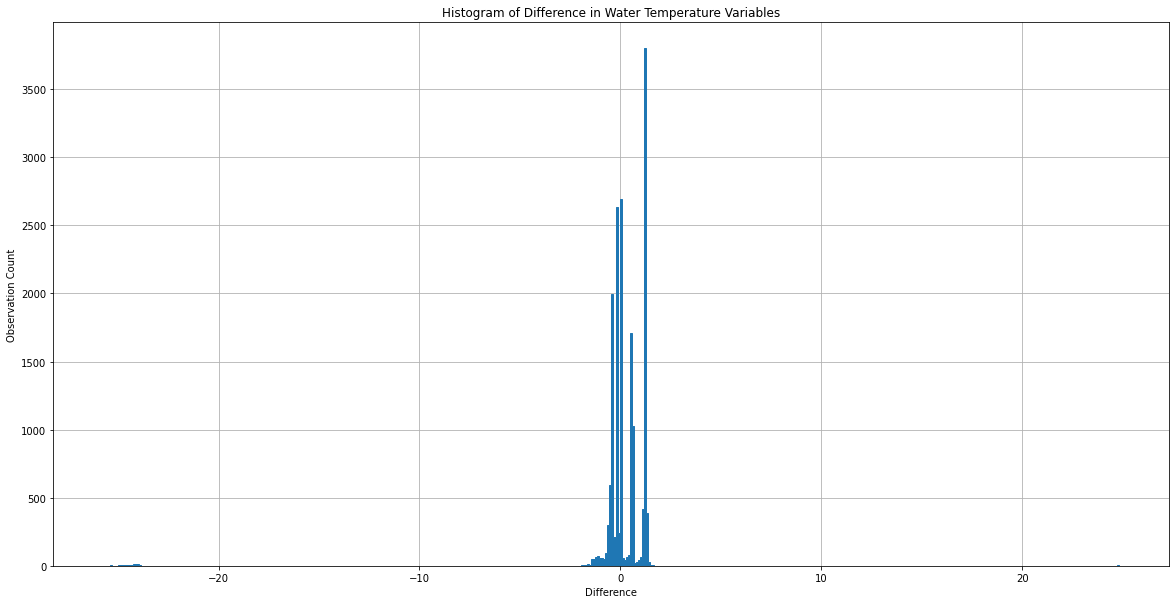

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))

water_temperature_diff.hist(bins=500, histtype='step', fill= True)

plt.title('Histogram of Difference in Water Temperature Variables')
plt.xlabel('Difference')
plt.ylabel('Observation Count')

plt.show()

In [59]:
NOAA_full_dat[['water_temperature (degrees Celsius)',
               'water_temperature_c6 (degrees Celsius)',
               'water_temp_c6 (degrees Celsius)',
               'ctd temperature (°c)',
               'sample temperature (°c)']].describe()

,water_temperature (degrees Celsius),water_temperature_c6 (degrees Celsius),water_temp_c6 (degrees Celsius),ctd temperature (°c),sample temperature (°c)
count,215715.000000,25044.000000,10008.000000,1317.000000,54.000000
mean,21.660908,20.888143,22.364602,21.997418,24.072222
std,4.693439,4.173523,2.360386,3.652731,2.368935
min,0.000000,-2.000000,15.070000,2.400000,19.000000
25%,19.870000,19.580000,20.570000,20.300000,22.200000
50%,22.920000,21.970000,22.620000,22.800000,24.200000
75%,24.710000,23.610000,24.240000,24.600000,26.150000
max,31.310000,41.520000,27.960000,29.700000,28.300000


The variables `water_temp_c6 (degrees Celsius)`, `ctd temperature (°c)` and `sample temperature (°c)` are likely taken from warmer months given its range, median value and smaller standard deviation compared to the other two water temperature variables.

We need to check if the different water temperature columns are mutually exclusive ie. if there is only one populated water temperature column per row. 

In [64]:
print(NOAA_full_dat.loc[NOAA_full_dat['water_temperature (degrees Celsius)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['water_temperature_c6 (degrees Celsius)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['water_temp_c6 (degrees Celsius)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['ctd temperature (°c)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['sample temperature (°c)'].notnull(), 'station'].unique())

['WE02' 'WE04' 'WE08' 'WE13']
----------
['WE02' 'WE04' 'WE08']
----------
['WE02']
----------
['Small_boat_2012_2018' 'Small_boat_2019']
----------
['Small_boat_2012_2018']


In [16]:
# NOAA_full_dat[(NOAA_full_dat['water_temperature (degrees Celsius)'].notnull()) & (NOAA_full_dat['water_temperature_c6 (degrees Celsius)'].notnull()) & (NOAA_full_dat['water_temp_c6 (degrees Celsius)'].notnull())]

# NOAA_full_dat[(NOAA_full_dat['water_temperature_c6 (degrees Celsius)'].notnull()) & (NOAA_full_dat['water_temp_c6 (degrees Celsius)'].notnull())]

NOAA_full_dat[(NOAA_full_dat['ctd temperature (°c)'].notnull()) & (NOAA_full_dat['sample temperature (°c)'].notnull())]

(54, 113)

The variables `water_temperature_c6 (degrees Celsius)` and `water_temp_c6 (degrees Celsius)` are mutually exclusive. However, `water_temperature (degrees Celsius)` overlaps with these two variables each. 

The variables `sample temperature (°c)` and `ctd temperature (°c)` are specific to the small boat datasets. The former is for small boat observations from 2012 while the latter is for small boat observations from 2013 to 2019.

In [60]:
# combine temperature columns
# NOAA_full_dat['water_temp_celsius_combined'] = NOAA_full_dat['water_temperature (degrees Celsius)'].combine_first(NOAA_full_dat['water_temperature_c6 (degrees Celsius)'])


There are 54 observations for the variable `sample temperature (°c)`. These rows are from the Small_boat_2012_2018 data set.

In [70]:
NOAA_full_dat.loc[(NOAA_full_dat['water_temperature (degrees Celsius)'].notnull())&(NOAA_full_dat['water_temperature_c6 (degrees Celsius)'].notnull())]

,timestamp (UTC),wave_height (meter),wave_direction (degrees),wave_period (seconds),wind_speed (meters per second),wind_direction (degrees),water_temperature (degrees Celsius),conductivity (micorosiemens per centimeter),specific_conductivity (micorosiemens per centimeter),total_dissolved_solids (milligrams per liter),ph,ph_mv (millivolts),oxidation_reduction_potential (millivolts),flourescent_dissolved_organic_matter (RFU),flourescent_dissolved_organic_matter_qsu (quinine sulfate units),turbidity (FNU),chlorophylla_rfu (RFU),chlorophylla (micrograms per liter),phycocyanin_rfu (RFU),phycocyanin (micrograms per liter),organic_dissolved_oxygen_saturation (%),organic_dissolved_oxygen (milligrams per liter),depth (meter),turbidity_c6 (NTU),phycoerythrin_c6 (RFU),phycocyanin_c6 (RFU),chlorophylla_c6 (RFU),colored_dissolved_organic_matter_c6 (ppb),depth_c6 (meter),water_temperature_c6 (degrees Celsius),station,longitude (decimal deg),latitude (decimal deg),site,phosphate (micrograms per liter),phosphate_flags,run_number,run_number_flags,wind_speed_max (meters per second),wind_speed_max_flags,wind_speed_mean (meters per second),wind_speed_mean_flags,wind_direction_mean (degrees),wind_direction_mean_flags,air_temp (degrees Celsius),air_temp_flags,barometric_pressure (mbar),barometric_pressure_flags,depth (meters),depth_flags,water_temperature_flags,specific_conductivity (millisiemens per centimeter),specific_conductivity_flags,ph (pH),ph_flags,turbidity (NTU),turbidity_flags,organic_dissolved_oxygen_saturation_flags,organic_dissolved_oxygen_flags,chlorophylla (RFU),chlorophylla_flags,phycocyanin (RFU),phycocyanin_flags,flourescent_dissolved_organic_matter_flags,turbidty_c6_flags,phycoerythrin_c6_flags,phycocyanin_c6_flags,chlorophylla_c6_flags,colored_dissolved_organic_matter_c6_flags,depth_c6 (meters),depth_c6_flags,water_temp_c6 (degrees Celsius),water_temp_c6_flags,no3m_suna (micromoles per liter),no3m_suna_flags,no3_suna (milligrams per liter),no3_suna_flags,turbidity_c6_flags,water_temperature_c6_flags,organic_dissolved_oxygen.1 (milligrams per liter),date,station depth (m),sample depth (m),sample depth (category),local time (eastern time zone),wind speed (knots),wave height (ft),sky,secchi depth (m),sample temperature (°c),ctd temperature (°c),ctd specific conductivity (µs/cm),ctd beam attenuation (m-1),ctd tramission (%),ctd dissolved oxygen (mg/l),ctd photosynthetically active radiation (µe/m2/s),turbidity (ntu),particulate microcystin (µg/l),dissolved microcystin (µg/l),extracted phycocyanin (µg/l),extracted chlorophyll a (µg/l),total phosphorus (µg p/l),total dissolved phosphorus (µg p/l),soluble reactive phosphorus (µg p/l),ammonia (µg n/l),nitrate + nitrite (mg n/l),urea (µg n/l),particulate organic carbon (mg/l),particulate organic nitrogen (mg/l),dissolved organic carbon (mg/l),colored dissolved organic material absorbance (m-1) at 400nm,total suspended solids (mg/l),volatile suspended solids (mg/l),water_temp_celsius_combined
1,5/22/2014 23:00,0.0777,63.6425,1.2024,4.0824,275.8586,17.1343,301.925,355.325,230.75,8.2975,-92.85,228.850,3.95,11.8575,3.0275,0.8175,3.1900,-0.4900,-0.4900,114,10.975,3.62650,3.1175,363.90,10.16,662.60,799.00,3.4300,17.1175,WE02,-83.330,41.762,WE02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.1343
2,5/23/2014 0:00,0.0755,67.8831,1.1671,4.3341,286.8209,17.0682,296.850,349.850,227.50,8.2875,-92.075,231.350,3.4475,10.3375,2.9400,0.8775,3.4225,-0.4875,-0.4875,113.3,10.9225,3.62525,3.0100,328.56,9.31,517.00,761.70,3.4300,17.0550,WE02,-83.330,41.762,WE02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### Depth

There are five variables related to depth:
- `depth_c6 (meter)`
- `depth_c6 (meters)`
- `sample depth (m)`
- `depth (meters)`
- `sample depth (category)`

In [98]:
NOAA_full_dat[['depth_c6 (meter)', 'depth_c6 (meters)', 'sample depth (m)', 'depth (meters)', 'sample depth (category)']].describe()

,depth_c6 (meter),depth_c6 (meters),sample depth (m),depth (meters)
count,25044.000000,10008.000000,1446.000000,211538.000000
mean,1.526927,1.001017,2.009440,2.115482
std,4.163889,0.105778,2.273455,415.834086
min,0.000000,0.210000,0.000000,-0.090000
25%,0.830000,0.960000,0.750000,0.991000
50%,1.030000,1.020000,0.750000,1.054000
75%,1.230000,1.100000,3.600000,1.130000
max,387.510000,1.310000,8.700000,191256.000000


In [62]:
# check for which stations each variable is populated for
print('depth_c6 (meter):', NOAA_full_dat.loc[NOAA_full_dat['depth_c6 (meter)'].notnull() == True, 'station'].unique())
print('----------')
print('depth_c6 (meters):', NOAA_full_dat.loc[NOAA_full_dat['depth_c6 (meter)'].notnull() == True, 'station'].unique())
print('----------')
print('sample depth (m):', NOAA_full_dat.loc[NOAA_full_dat['depth_c6 (meter)'].notnull() == True, 'station'].unique())
print('----------')
print('depth (meters):', NOAA_full_dat.loc[NOAA_full_dat['depth (meters)'].notnull() == True, 'station'].unique())

depth_c6 (meter): ['WE02' 'WE04' 'WE08']
----------
depth_c6 (meters): ['WE02' 'WE04' 'WE08']
----------
sample depth (m): ['WE02' 'WE04' 'WE08']
----------
depth (meters): ['WE02' 'WE04' 'WE08' 'WE13']


### Secchi Depth

There are some non-numeric values in the `secchi depth (m)` column. We will double check what these rows contain. 

In [30]:
nonnull_secchi = NOAA_full_dat['secchi depth (m)'][NOAA_full_dat['secchi depth (m)'].notnull()]
print('Number of non-null secchi observations:', nonnull_secchi.shape[0])
print('Number of non-null secchi observations with non-numeric characters:', nonnull_secchi.str.replace(pat = '.', repl = '', regex = False).str.isdigit().sum())

Number of non-null secchi observations: 978
Number of non-null secchi observations with non-numeric characters: 976


In [82]:
NOAA_full_dat['secchi depth (m)'].loc[NOAA_full_dat['secchi depth (m)'].str.replace(pat = '.', repl = '', regex = False).str.isdigit() == False]

278187       .
278885    <0.1
Name: secchi depth (m), dtype: object

There are only two rows out of 978 non-null rows in `secchi depth (m)` that are strings (non-numeric). Hence, we will coerce the non-numeric rows into `NaN`. 

In [31]:
# Cast secchi depth (m) to numeric
NOAA_full_dat['secchi depth (m)'] = pd.to_numeric(NOAA_full_dat['secchi depth (m)'], errors = 'coerce')

### Date 

There are three variables related to date: `date`, `timestamp (UTC)` and `local time (eastern time zone)`. The first variable is of %-m/%d/%Y format, the second is of %-m/%d/%Y %H %M format, and the last variable is of %H %M format (24-hour notation time). The variables `date` and `local time (eastern time zone)` are in tandem, found in the small boat data sets. 

*Not sure if granularity of time is necessary, but keep it for now. Note that small boat data sets are in EST whereas timestamp (UTC) is in UTC time zone!* 

In [15]:
# Convert dates and times from string to date object
NOAA_full_dat['date'] = pd.to_datetime(NOAA_full_dat['date'])

## May need to break down further to year, month, day, time

In [25]:
print(NOAA_full_dat.loc[NOAA_full_dat['timestamp (UTC)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['date'].notnull(), 'station'].unique())

['WE02' 'WE04' 'WE08' 'WE13']
----------
['Small_boat_2012_2018' 'Small_boat_2019']


In [30]:
NOAA_full_dat['timestamp (UTC)'][NOAA_full_dat['timestamp (UTC)'].notnull()].head()

0    5/22/2014 22:00
1    5/22/2014 23:00
2     5/23/2014 0:00
3     5/23/2014 1:00
4     5/23/2014 2:00
Name: timestamp (UTC), dtype: object

In [29]:
NOAA_full_dat['date'][NOAA_full_dat['date'].notnull()].head()

277619   2012-05-15
277620   2012-05-15
277621   2012-05-15
277622   2012-05-15
277623   2012-05-31
Name: date, dtype: datetime64[ns]

In [32]:
(70.1+76.04)*2/3

97.42666666666666

In [18]:
# tstmo, tstday, tstyr, tsttime = re.split('[/ \\s]', NOAA_full_dat['timestamp (UTC)'][0])

# Check range of months in timestamp (UTC) variables
timestamp_notnull = NOAA_full_dat.loc[NOAA_full_dat['timestamp (UTC)'].notnull(), 'timestamp (UTC)']
timestamp_notnull.str.split(pat = '[/ \\s]').map(lambda x: x[0]).unique()

array(['5', '6', '7', '8', '9', '10', '11', '4', 'NA-99-99', '2000-00-00',
       '#VALUE!'], dtype=object)

Unavailable dates in the `timestamp (UTC)` variable are coded as `NA-99-99 99:99:99`. As well, there are 5 rows with the date `2000-00-00 00:00:00` and 3 rows with `#VALUE!` randomly scattered throughout the `timestamp (UTC)` series. These must be cleaned up. 

Looking at these rows, the majority of the other variables are also NaN values, so these observations are virtually useless. I set the value of `timestamp (UTC)` to NaN for the rows with the values `NA-99-99 99:99:99`, `2000-00-00 00:00:00`and `#VALUE!` to standardize NA entries.

In [17]:
NOAA_full_dat.iloc[timestamp_notnull[timestamp_notnull.str.startswith(
    ('NA-99-99 99:99:99', '2000-00-00 00:00:00', '#VALUE!'))].index, ]

,timestamp (UTC),wave_height (meter),wave_direction (degrees),wave_period (seconds),wind_speed (meters per second),wind_direction (degrees),water_temperature (degrees Celsius),conductivity (micorosiemens per centimeter),specific_conductivity (micorosiemens per centimeter),total_dissolved_solids (milligrams per liter),ph,ph_mv (millivolts),oxidation_reduction_potential (millivolts),flourescent_dissolved_organic_matter (RFU),flourescent_dissolved_organic_matter_qsu (quinine sulfate units),turbidity (FNU),chlorophylla_rfu (RFU),chlorophylla (micrograms per liter),phycocyanin_rfu (RFU),phycocyanin (micrograms per liter),organic_dissolved_oxygen_saturation (%),organic_dissolved_oxygen (milligrams per liter),depth (meter),turbidity_c6 (NTU),phycoerythrin_c6 (RFU),phycocyanin_c6 (RFU),chlorophylla_c6 (RFU),colored_dissolved_organic_matter_c6 (ppb),depth_c6 (meter),water_temperature_c6 (degrees Celsius),station,longitude (decimal deg),latitude (decimal deg),site,phosphate (micrograms per liter),phosphate_flags,run_number,run_number_flags,wind_speed_max (meters per second),wind_speed_max_flags,wind_speed_mean (meters per second),wind_speed_mean_flags,wind_direction_mean (degrees),wind_direction_mean_flags,air_temp (degrees Celsius),air_temp_flags,barometric_pressure (mbar),barometric_pressure_flags,depth (meters),depth_flags,water_temperature_flags,specific_conductivity (millisiemens per centimeter),specific_conductivity_flags,ph (pH),ph_flags,turbidity (NTU),turbidity_flags,organic_dissolved_oxygen_saturation_flags,organic_dissolved_oxygen_flags,chlorophylla (RFU),chlorophylla_flags,phycocyanin (RFU),phycocyanin_flags,flourescent_dissolved_organic_matter_flags,turbidty_c6_flags,phycoerythrin_c6_flags,phycocyanin_c6_flags,chlorophylla_c6_flags,colored_dissolved_organic_matter_c6_flags,depth_c6 (meters),depth_c6_flags,water_temp_c6 (degrees Celsius),water_temp_c6_flags,no3m_suna (micromoles per liter),no3m_suna_flags,no3_suna (milligrams per liter),no3_suna_flags,turbidity_c6_flags,water_temperature_c6_flags,date,station depth (m),sample depth (m),sample depth (category),local time (eastern time zone),wind speed (knots),wave height (ft),sky,secchi depth (m),sample temperature (°c),ctd temperature (°c),ctd specific conductivity (µs/cm),ctd beam attenuation (m-1),ctd tramission (%),ctd dissolved oxygen (mg/l),ctd photosynthetically active radiation (µe/m2/s),turbidity (ntu),particulate microcystin (µg/l),dissolved microcystin (µg/l),extracted phycocyanin (µg/l),extracted chlorophyll a (µg/l),total phosphorus (µg p/l),total dissolved phosphorus (µg p/l),soluble reactive phosphorus (µg p/l),ammonia (µg n/l),nitrate + nitrite (mg n/l),urea (µg n/l),particulate organic carbon (mg/l),particulate organic nitrogen (mg/l),dissolved organic carbon (mg/l),colored dissolved organic material absorbance (m-1) at 400nm,total suspended solids (mg/l),volatile suspended solids (mg/l)
40057,NA-99-99 99:99:99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WE02,-83.330,41.762,WE02,NaN,NA NA 2 1 1,NaN,NA 2 2 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60596,NA-99-99 99:99:99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WE02,-83.330,41.762,WE02,NaN,NA NA 2 1 1,NaN,NA 2 2 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77324,2000-00-00 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [19]:
# Set rows for which timestamp (UTC) = NA-99-99 99:99:99 to NaN
NOAA_full_dat.loc[NOAA_full_dat['timestamp (UTC)'].isin([
    'NA-99-99 99:99:99', '2000-00-00 00:00:00', '#VALUE!']), 'timestamp (UTC)'] = float('NaN')

In [20]:
# Convert timestamp (UTC) variable to pandas time 
NOAA_full_dat['timestamp (UTC)'] = pd.to_datetime(NOAA_full_dat['timestamp (UTC)'])

In [ ]:
# Would it be helpful to have speicific columns for year, month, day? Would be easier for processing 

### Phosphorus

Phosphorus is an important variable to look at as it is a limiting factor to algae bloom growth (***cite here!!***).

There are four variables related to phosphorus:
- `phosphate (micrograms per liter)`
- `total phosphorus (µg p/l)`
- `total dissolved phosphorus (µg p/l)`
- `soluble reactive phosphorus (µg p/l)`

In [217]:
print(NOAA_full_dat.loc[NOAA_full_dat['phosphate (micrograms per liter)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['total phosphorus (µg p/l)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['total dissolved phosphorus (µg p/l)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['soluble reactive phosphorus (µg p/l)'].notnull(), 'station'].unique())

['WE02' 'WE04' 'WE08' 'WE13']
----------
['Small_boat_2012_2018' 'Small_boat_2019']
----------
['Small_boat_2012_2018' 'Small_boat_2019']
----------
['Small_boat_2012_2018' 'Small_boat_2019']


The phosphate variable, `phosphate (micrograms per liter)`, is found in the 'WE__' data sets whereas the phosphorus variables are found in the small boat data sets. 

In [225]:
NOAA_full_dat['phosphate (micrograms per liter)'].notnull()

,timestamp (UTC),wave_height (meter),wave_direction (degrees),wave_period (seconds),wind_speed (meters per second),wind_direction (degrees),water_temperature (degrees Celsius),conductivity (micorosiemens per centimeter),specific_conductivity (micorosiemens per centimeter),total_dissolved_solids (milligrams per liter),ph,ph_mv (millivolts),oxidation_reduction_potential (millivolts),flourescent_dissolved_organic_matter (RFU),flourescent_dissolved_organic_matter_qsu (quinine sulfate units),turbidity (FNU),chlorophylla_rfu (RFU),chlorophylla (micrograms per liter),phycocyanin_rfu (RFU),phycocyanin (micrograms per liter),organic_dissolved_oxygen_saturation (%),organic_dissolved_oxygen (milligrams per liter),depth (meter),turbidity_c6 (NTU),phycoerythrin_c6 (RFU),phycocyanin_c6 (RFU),chlorophylla_c6 (RFU),colored_dissolved_organic_matter_c6 (ppb),depth_c6 (meter),water_temperature_c6 (degrees Celsius),station,longitude (decimal deg),latitude (decimal deg),site,phosphate (micrograms per liter),phosphate_flags,run_number,run_number_flags,wind_speed_max (meters per second),wind_speed_max_flags,wind_speed_mean (meters per second),wind_speed_mean_flags,wind_direction_mean (degrees),wind_direction_mean_flags,air_temp (degrees Celsius),air_temp_flags,barometric_pressure (mbar),barometric_pressure_flags,depth (meters),depth_flags,water_temperature_flags,specific_conductivity (millisiemens per centimeter),specific_conductivity_flags,ph (pH),ph_flags,turbidity (NTU),turbidity_flags,organic_dissolved_oxygen_saturation_flags,organic_dissolved_oxygen_flags,chlorophylla (RFU),chlorophylla_flags,phycocyanin (RFU),phycocyanin_flags,flourescent_dissolved_organic_matter_flags,turbidty_c6_flags,phycoerythrin_c6_flags,phycocyanin_c6_flags,chlorophylla_c6_flags,colored_dissolved_organic_matter_c6_flags,depth_c6 (meters),depth_c6_flags,water_temp_c6 (degrees Celsius),water_temp_c6_flags,no3m_suna (micromoles per liter),no3m_suna_flags,no3_suna (milligrams per liter),no3_suna_flags,turbidity_c6_flags,water_temperature_c6_flags,organic_dissolved_oxygen.1 (milligrams per liter),date,station depth (m),sample depth (m),sample depth (category),local time (eastern time zone),wind speed (knots),wave height (ft),sky,secchi depth (m),sample temperature (°c),ctd temperature (°c),ctd specific conductivity (µs/cm),ctd beam attenuation (m-1),ctd tramission (%),ctd dissolved oxygen (mg/l),ctd photosynthetically active radiation (µe/m2/s),turbidity (ntu),particulate microcystin (µg/l),dissolved microcystin (µg/l),extracted phycocyanin (µg/l),extracted chlorophyll a (µg/l),total phosphorus (µg p/l),total dissolved phosphorus (µg p/l),soluble reactive phosphorus (µg p/l),ammonia (µg n/l),nitrate + nitrite (mg n/l),urea (µg n/l),particulate organic carbon (mg/l),particulate organic nitrogen (mg/l),dissolved organic carbon (mg/l),colored dissolved organic material absorbance (m-1) at 400nm,total suspended solids (mg/l),volatile suspended solids (mg/l)
3919,2014-05-22 18:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WE02,-83.330,41.762,WE02,4.7,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3920,2014-05-22 19:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WE02,-83.330,41.762,WE02,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3921,2014-05-22 20:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [319]:
# get details on phosphorus variables
NOAA_full_dat[['phosphate (micrograms per liter)',
              'total phosphorus (µg p/l)',
              'total dissolved phosphorus (µg p/l)',
              'soluble reactive phosphorus (µg p/l)']].describe()

,phosphate (micrograms per liter),total phosphorus (µg p/l),total dissolved phosphorus (µg p/l)
count,41579.000000,1013.000000,1015.000000
mean,7.888925,76.215490,20.008156
std,141.494424,123.729539,27.873616
min,-458.500000,4.000000,0.160000
25%,-0.300000,26.690000,4.970000
50%,1.600000,49.920000,9.160000
75%,5.900000,84.600000,22.016000
max,15120.000000,2482.240000,273.580000


In [35]:
print('There are', sum(NOAA_full_dat['phosphate (micrograms per liter)'] < 0), 'negative phosphate observations out of', sum(NOAA_full_dat['phosphate (micrograms per liter)'].notnull()), 'observations in total.')
NOAA_full_dat.loc[NOAA_full_dat['phosphate (micrograms per liter)'] < 0, 'phosphate (micrograms per liter)'].describe()

There are 11379 negative phosphate observations out of 41579 observations in total.


count    11379.000000
mean        -5.459170
std         16.337516
min       -458.500000
25%         -5.600000
50%         -2.000000
75%         -0.700000
max         -0.100000
Name: phosphate (micrograms per liter), dtype: float64

In [303]:
# how to format numbers?
11379/41579 

0.2736718054787272

Not sure how to interpret negative phosphate observations!? There are also a lot of negative observations... more than 25% of the total phosphate observations. This [thread](https://www.researchgate.net/post/How_can_I_explain_negative_value_of_water_quality_parameters_nutrients_like_Nitrite_Nitrate_Phosphate) on ResearchGate suggests that this is a measurement error. For EDA, I will ignore negative values.

In [23]:
print('total phosphorus (µg p/l):', sum(NOAA_full_dat['total phosphorus (µg p/l)'].notnull()))
print('----------')
print('total dissolved phosphorus (µg p/l):', sum(NOAA_full_dat['total dissolved phosphorus (µg p/l)'].notnull()))
print('----------')
print('soluble reactive phosphorus (µg p/l):', sum(NOAA_full_dat['soluble reactive phosphorus (µg p/l)'].notnull()))

total phosphorus (µg p/l): 1013
----------
total dissolved phosphorus (µg p/l): 1015
----------
soluble reactive phosphorus (µg p/l): 1009


In [266]:
NOAA_full_dat[NOAA_full_dat['total phosphorus (µg p/l)'].notnull() &
              NOAA_full_dat['total dissolved phosphorus (µg p/l)'].notnull() &
              NOAA_full_dat['soluble reactive phosphorus (µg p/l)'].notnull()].shape

(1002, 113)

All three phosphorus observations have non-null values for 1002 rows. There are a few rows where there are at least one of these variables are null. 

In [305]:
phos_rows = NOAA_full_dat[['total phosphorus (µg p/l)', 'total dissolved phosphorus (µg p/l)', 'soluble reactive phosphorus (µg p/l)']].dropna(thresh = 1)

In [265]:
NOAA_full_dat.iloc[list(set(list(phos_rows[phos_rows['total phosphorus (µg p/l)'].isnull()].index) + list(phos_rows[phos_rows['total dissolved phosphorus (µg p/l)'].isnull()].index) + list(phos_rows[phos_rows['soluble reactive phosphorus (µg p/l)'].isnull()].index)))]

,timestamp (UTC),wave_height (meter),wave_direction (degrees),wave_period (seconds),wind_speed (meters per second),wind_direction (degrees),water_temperature (degrees Celsius),conductivity (micorosiemens per centimeter),specific_conductivity (micorosiemens per centimeter),total_dissolved_solids (milligrams per liter),ph,ph_mv (millivolts),oxidation_reduction_potential (millivolts),flourescent_dissolved_organic_matter (RFU),flourescent_dissolved_organic_matter_qsu (quinine sulfate units),turbidity (FNU),chlorophylla_rfu (RFU),chlorophylla (micrograms per liter),phycocyanin_rfu (RFU),phycocyanin (micrograms per liter),organic_dissolved_oxygen_saturation (%),organic_dissolved_oxygen (milligrams per liter),depth (meter),turbidity_c6 (NTU),phycoerythrin_c6 (RFU),phycocyanin_c6 (RFU),chlorophylla_c6 (RFU),colored_dissolved_organic_matter_c6 (ppb),depth_c6 (meter),water_temperature_c6 (degrees Celsius),station,longitude (decimal deg),latitude (decimal deg),site,phosphate (micrograms per liter),phosphate_flags,run_number,run_number_flags,wind_speed_max (meters per second),wind_speed_max_flags,wind_speed_mean (meters per second),wind_speed_mean_flags,wind_direction_mean (degrees),wind_direction_mean_flags,air_temp (degrees Celsius),air_temp_flags,barometric_pressure (mbar),barometric_pressure_flags,depth (meters),depth_flags,water_temperature_flags,specific_conductivity (millisiemens per centimeter),specific_conductivity_flags,ph (pH),ph_flags,turbidity (NTU),turbidity_flags,organic_dissolved_oxygen_saturation_flags,organic_dissolved_oxygen_flags,chlorophylla (RFU),chlorophylla_flags,phycocyanin (RFU),phycocyanin_flags,flourescent_dissolved_organic_matter_flags,turbidty_c6_flags,phycoerythrin_c6_flags,phycocyanin_c6_flags,chlorophylla_c6_flags,colored_dissolved_organic_matter_c6_flags,depth_c6 (meters),depth_c6_flags,water_temp_c6 (degrees Celsius),water_temp_c6_flags,no3m_suna (micromoles per liter),no3m_suna_flags,no3_suna (milligrams per liter),no3_suna_flags,turbidity_c6_flags,water_temperature_c6_flags,organic_dissolved_oxygen.1 (milligrams per liter),date,station depth (m),sample depth (m),sample depth (category),local time (eastern time zone),wind speed (knots),wave height (ft),sky,secchi depth (m),sample temperature (°c),ctd temperature (°c),ctd specific conductivity (µs/cm),ctd beam attenuation (m-1),ctd tramission (%),ctd dissolved oxygen (mg/l),ctd photosynthetically active radiation (µe/m2/s),turbidity (ntu),particulate microcystin (µg/l),dissolved microcystin (µg/l),extracted phycocyanin (µg/l),extracted chlorophyll a (µg/l),total phosphorus (µg p/l),total dissolved phosphorus (µg p/l),soluble reactive phosphorus (µg p/l),ammonia (µg n/l),nitrate + nitrite (mg n/l),urea (µg n/l),particulate organic carbon (mg/l),particulate organic nitrogen (mg/l),dissolved organic carbon (mg/l),colored dissolved organic material absorbance (m-1) at 400nm,total suspended solids (mg/l),volatile suspended solids (mg/l)
278944,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Small_boat_2019,-83.1950,41.8311,WE4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-22,8.93,0.75,Surface,9:23,13.67,2.60,partly cloudy,1.5,NaN,25.8,270.9,1.9,63,6.1,750.79,4.33,1.7,<0.1,54.54,18.40,29.96,3.88,NaN,NaN,NaN,NaN,1.51,0.30,NaN,0.880,3.92,3.41
278945,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Small_boat_2019,-83.3865,41.7051,WE6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-22,3.26,0.75,Surface,12:25,7.06,0.98,mostly sunny,0.5,NaN,27.1,445.9,9,10.9,6.6,122.84,25.80,11.41,<0.1,211.41,97.50,138.13,48.49,NaN,NaN,NaN,NaN,4.28,0.77,NaN

In [306]:
NOAA_full_dat.iloc[list(set(list(phos_rows[phos_rows['total phosphorus (µg p/l)'].isnull()].index) + list(phos_rows[phos_rows['total dissolved phosphorus (µg p/l)'].isnull()].index) + list(phos_rows[phos_rows['soluble reactive phosphorus (µg p/l)'].isnull()].index)))].shape

(16, 112)

### Dissolved Oxygen

There are three variables related to dissolved oxygen:
- `organic_dissolved_oxygen_saturation (%)`
- `organic_dissolved_oxygen (milligrams per liter)`
- `ctd dissolved oxygen (mg/l)`

In [22]:
[var for var in NOAA_full_dat.columns if 'oxy' in var]

['organic_dissolved_oxygen_saturation (%)',
 'organic_dissolved_oxygen (milligrams per liter)',
 'organic_dissolved_oxygen_saturation_flags',
 'organic_dissolved_oxygen_flags',
 'ctd dissolved oxygen (mg/l)']

In [24]:
print('organic_dissolved_oxygen_saturation (%):', NOAA_full_dat.loc[NOAA_full_dat['organic_dissolved_oxygen_saturation (%)'].notnull(), 'station'].unique())
print('----------')
print('organic_dissolved_oxygen (milligrams per liter):', NOAA_full_dat.loc[NOAA_full_dat['organic_dissolved_oxygen (milligrams per liter)'].notnull(), 'station'].unique())
print('----------')
print('ctd dissolved oxygen (mg/l):', NOAA_full_dat.loc[NOAA_full_dat['ctd dissolved oxygen (mg/l)'].notnull(), 'station'].unique())

organic_dissolved_oxygen_saturation (%): ['WE02' 'WE04' 'WE08' 'WE13']
----------
organic_dissolved_oxygen (milligrams per liter): ['WE02' 'WE04' 'WE08' 'WE13']
----------
ctd dissolved oxygen (mg/l): ['Small_boat_2012_2018' 'Small_boat_2019']


In [25]:
# get details on dissolved oxygen variables
# NOTE THAT ctd dissolved oxygen is grouped! It's only part of the small boat sets

NOAA_full_dat[['organic_dissolved_oxygen_saturation (%)',
               'organic_dissolved_oxygen (milligrams per liter)',
               'ctd dissolved oxygen (mg/l)']].describe()

,organic_dissolved_oxygen_saturation (%),organic_dissolved_oxygen (milligrams per liter)
count,209222.000000,209222.000000
mean,106.329511,9.229650
std,22.372860,1.841503
min,0.000000,0.000000
25%,96.900000,8.530000
50%,103.200000,9.170000
75%,114.400000,9.940000
max,261.700000,21.170000


In [28]:
print('Number of rows in which organic dissolved oxygen saturation (%) and (milligrams per liter) are not null:', 
      NOAA_full_dat.loc[NOAA_full_dat['organic_dissolved_oxygen (milligrams per liter)'].notnull() &
                        NOAA_full_dat['organic_dissolved_oxygen_saturation (%)'].notnull()].shape[0])

Number of rows in which organic dissolved oxygen saturation (%) and (milligrams per liter) are not null: 209222


The variables `organic_dissolved_oxygen_saturation (%)` and `organic_dissolved_oxygen (milligrams per liter)` are observations from the WE__ data sets and non-null for the same rows. Since these variables represent the same attribute, I will choose one for organic dissolved oxygen. For the sake of uniformity, I will select the milligram per liter version.

### pH

There are three variables related to pH:
- `ph`
- `ph_mv (millivolts)`
- `ph (pH)`

In [220]:
print('ph:', NOAA_full_dat.loc[NOAA_full_dat['ph'].notnull(), 'station'].unique())
print('----------')
print('ph_mv (millivolts):', NOAA_full_dat.loc[NOAA_full_dat['ph_mv (millivolts)'].notnull(), 'station'].unique())
print('----------')
print('ph (pH):', NOAA_full_dat.loc[NOAA_full_dat['ph (pH)'].notnull(), 'station'].unique())

NOAA_full_dat[['ph',
               'ph_mv (millivolts)',
               'ph (pH)']].describe()

ph: ['WE02' 'WE04' 'WE08' 'WE13']
----------
ph_mv (millivolts): ['WE02' 'WE04' 'WE08' 'WE13']
----------
ph (pH): ['WE02' 'WE04' 'WE08' 'WE13']


,ph,ph (pH)
count,24203.000000,185019.000000
mean,-2.243070,8.381937
std,60.056282,1.298014
min,-411.275000,0.000000
25%,8.490000,8.250000
50%,8.910000,8.500000
75%,9.140000,8.790000
max,9.850000,17.900000


All three pH variables are from the WE__ data sets. It seems that `ph` and `ph (pH)` are names referring to the same measurement and so should be merged into one column. Looking at the original individual data sets in the `NOAA_sets` dictionary, 'pH' appears as a measurement unit in WE__ data sets from 2015 onwards. We look at `ph_mv (millivolts)` in more detail. 

In [95]:
# NOAA_full_dat['ph_mv (millivolts)'].astype(float) 

np.setdiff1d(NOAA_full_dat[NOAA_full_dat['ph_mv (millivolts)'].notnull()].index.tolist(),
             NOAA_full_dat[NOAA_full_dat['ph_mv (millivolts)'].str.contains('\s') == True].index.tolist())

NOAA_full_dat[1:3522]['station'].unique()
# flag issue again for this!! Could ignore since we can using pH anyway... 

array([   1,    2,    3, ..., 3519, 3520, 3521])

I will check for which stations and time periods that `ph_mv (millivolts)` are flag values.

In [176]:
ph_mv_check = NOAA_full_dat.loc[NOAA_full_dat['ph_mv (millivolts)'].str.contains('\s') == True, ['station', 'timestamp (UTC)', 'ph_mv (millivolts)']]
ph_mv_check['timestamp year'] = ph_mv_check['timestamp (UTC)'].dt.year 
print('ph_mv flag values are found in years:', ph_mv_check['timestamp year'].unique())
print('ph_mv flag values are found in stations:', ph_mv_check['station'].unique())

ph_mv flag values are found in years: [2015]
ph_mv flag values are found in stations: ['WE04' 'WE08' 'WE13']


Could the pH flags be missing in the 2015 sets of WE04, WE08 and WE13?

In [199]:
print(NOAA_full_dat.loc[NOAA_full_dat['ph_flags'].notnull(), 'timestamp (UTC)'].dt.year.unique())
print(NOAA_full_dat.loc[NOAA_full_dat['ph_flags'].notnull(), 'station'].unique())

ph_flag_check = NOAA_full_dat.loc[NOAA_full_dat['ph_flags'].notnull()]
ph_flag_check['timestamp year'] = NOAA_full_dat['timestamp (UTC)'].dt.year

ph_flag_check.groupby(['timestamp year','station']).size()

[2015 2016 2017 2018]
['WE02' 'WE04' 'WE08' 'WE13']


C:\Users\Angela\Documents\WPy64-3720\python-3.7.2.amd64\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


timestamp year  station
2015.0          WE02        9386
2016.0          WE02       15439
                WE04       15773
                WE08       14737
                WE13       10729
2017.0          WE02       17911
                WE04       17319
                WE08       14917
                WE13       12683
2018.0          WE02       15720
                WE04       12232
                WE08       14590
                WE13       14869
dtype: int64

In [200]:
print(NOAA_full_dat.loc[NOAA_full_dat['ph_mv (millivolts)'].notnull(), 'timestamp (UTC)'].dt.year.unique())
print(NOAA_full_dat.loc[NOAA_full_dat['ph_mv (millivolts)'].notnull(), 'station'].unique())

ph_mv_flag_check = NOAA_full_dat.loc[NOAA_full_dat['ph_mv (millivolts)'].notnull()]
ph_mv_flag_check['timestamp year'] = NOAA_full_dat['timestamp (UTC)'].dt.year

ph_mv_flag_check.groupby(['timestamp year','station']).size()

[2014 2015]
['WE02' 'WE04' 'WE08' 'WE13']


C:\Users\Angela\Documents\WPy64-3720\python-3.7.2.amd64\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


timestamp year  station
2014.0          WE02       3509
2015.0          WE04       9284
                WE08       4599
                WE13       6811
dtype: int64

In [216]:
NOAA_sets['WE02_2014_annual_summary']['ph_mv (millivolts)'].describe()

count    3509.000000
mean      -93.268267
std        40.753959
min      -147.175000
25%      -124.300000
50%      -105.425000
75%       -80.750000
max       -16.150000
Name: ph_mv (millivolts), dtype: float64

In [215]:
print('Number of non-null rows, WE02 2014:', 
      NOAA_sets['WE02_2014_annual_summary'][NOAA_sets['WE02_2014_annual_summary']['ph_mv (millivolts)'].notnull()].shape[0])
print(NOAA_sets['WE02_2014_annual_summary']['ph_mv (millivolts)'].astype(float))

print('---------------')

print('Number of non-null rows, WE04 2015:', 
      NOAA_sets['WE04_2015_annual_summary'][NOAA_sets['WE04_2015_annual_summary']['ph_mv (millivolts)'].notnull()].shape[0])
print(NOAA_sets['WE04_2015_annual_summary']['ph_mv (millivolts)'].str.contains('\s').sum())

print('---------------')

print('Number of non-null rows, WE08 2015:', 
      NOAA_sets['WE08_2015_annual_summary'][NOAA_sets['WE08_2015_annual_summary']['ph_mv (millivolts)'].notnull()].shape[0])
print(NOAA_sets['WE08_2015_annual_summary']['ph_mv (millivolts)'].str.contains('\s').sum())

print('---------------')

print('Number of non-null rows, WE13 2015:', 
      NOAA_sets['WE13_2015_annual_summary'][NOAA_sets['WE13_2015_annual_summary']['ph_mv (millivolts)'].notnull()].shape[0])
print(NOAA_sets['WE13_2015_annual_summary']['ph_mv (millivolts)'].str.contains('\s').sum())

Number of non-null rows, WE02 2014: 3509
0          NaN
1      -92.850
2      -92.075
3      -91.325
4      -90.925
         ...  
3914       NaN
3915       NaN
3916       NaN
3917       NaN
3918       NaN
Name: ph_mv (millivolts), Length: 3919, dtype: float64
---------------
Number of non-null rows, WE04 2015: 9284
9284
---------------
Number of non-null rows, WE08 2015: 4599
4599
---------------
Number of non-null rows, WE13 2015: 6811
6811


In the 2015 sets for WE04, WE08 and WE13 stations, `ph_mv (millivolts)` contains flag values. Since there is another variable for pH and because only less than 10% of the observations in the merged data set have non-null values for `ph_mv (millivolts)`, I will not use `ph_mv (millivolts)` but use `ph` and `ph (pH)` instead. 

The `describe` summary for `ph` and show that its mean value is -2.243070 and that its minimum value is -411.275000. This is strange as a pH reading that negative would mean there is a much larger issue than algae blooms in the lake. We will explore the negative readings for `ph` next. 

In [109]:
NOAA_sets['WE02_2015_annual_summary']['ph (pH)'].describe()

# there are some particularly low pH readings, check the ecdf of ph (PH)
NOAA_sets['WE02_2015_annual_summary']['ph (pH)'].quantile(0.01)

7.61

In [116]:
from statsmodels.distributions.empirical_distribution import ECDF

In [230]:
print(NOAA_full_dat['ph (pH)'].quantile(0.0201))

print(np.where(ECDF(NOAA_full_dat['ph (pH)']).x < 2)[0].max())
print(np.where(ECDF(NOAA_full_dat['ph (pH)']).x < 5)[0].max())
print(np.where(ECDF(NOAA_full_dat['ph (pH)']).x < 7)[0].max())

print('Percentile of ph (pH) observations less than 7:', 
      sum(NOAA_full_dat['ph (pH)'] < 7)/sum(NOAA_full_dat['ph (pH)'].notnull())) 

0.0
3736
3856
3866
Percentile of ph (pH) observations less than 7: 0.020895151308784502


C:\Users\Angela\Documents\WPy64-3720\python-3.7.2.amd64\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Angela\Documents\WPy64-3720\python-3.7.2.amd64\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
C:\Users\Angela\Documents\WPy64-3720\python-3.7.2.amd64\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [221]:
print(NOAA_full_dat['ph'].quantile(0.0201))

print(np.where(ECDF(NOAA_full_dat['ph']).x < 2)[0].max())
print(np.where(ECDF(NOAA_full_dat['ph']).x < 5)[0].max())
print(np.where(ECDF(NOAA_full_dat['ph']).x < 7)[0].max())

print('Proportion of ph observations less than 7:', 
      sum(NOAA_full_dat['ph'] < 7)/sum(NOAA_full_dat['ph'].notnull()))

-333.755995
1358
1364
1366
Percentile of ph observations less than 7: 0.004894618785876552


C:\Users\Angela\Documents\WPy64-3720\python-3.7.2.amd64\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Angela\Documents\WPy64-3720\python-3.7.2.amd64\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
C:\Users\Angela\Documents\WPy64-3720\python-3.7.2.amd64\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\Users\Angela\Documents\WPy64-3720\python-3.7.2.amd64\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


In [231]:
print(sum(NOAA_full_dat['ph'] < 0)/sum(NOAA_full_dat['ph'].notnull()))

print(sum(NOAA_full_dat['ph (pH)'] < 0)/sum(NOAA_full_dat['ph (pH)'].notnull()))

0.0561087468495641
0.0


In [247]:
print('Years with negative ph observations:', NOAA_full_dat.loc[(NOAA_full_dat['ph'].notnull()) & (NOAA_full_dat['ph'] < 0), 
                                                               'timestamp (UTC)'].dt.year.unique())
print('Stations with negative ph observations:', NOAA_full_dat.loc[(NOAA_full_dat['ph'].notnull()) & (NOAA_full_dat['ph'] < 0), 
                                                               'station'].unique())

Years with negative ph observations: [2014]
Stations with negative ph observations: ['WE02']


In [253]:
print('Summary of 2014 WE02 ph negative observations:\n{}\n'.format(
    NOAA_sets['WE02_2014_annual_summary'].loc[(NOAA_sets['WE02_2014_annual_summary']['ph'] < 0), 'ph'].describe()))
print('Summary of 2014 WE02 ph non-negative observations:\n{}'.format(
    NOAA_sets['WE02_2014_annual_summary'].loc[(NOAA_sets['WE02_2014_annual_summary']['ph'] >= 0), 'ph'].describe()))

Summary of 2014 WE02 ph negative observations:
count    1358.000000
mean     -188.884356
std       165.501414
min      -411.275000
25%      -382.871250
50%       -46.050000
75%       -35.886875
max       -21.250000
Name: ph, dtype: float64

Summary of 2014 WE02 ph non-negative observations:
count    2151.000000
mean        8.841509
std         0.509927
min         7.932500
25%         8.272500
50%         8.945000
75%         9.310000
max         9.652500
Name: ph, dtype: float64


In [258]:
sum(NOAA_sets['WE02_2014_annual_summary']['ph'].between(6, 7.5, inclusive = True))

0

It seems like there is a large chasm between the negative and the non-negative values for `ph` in the 2014 WE02 data set. It is likely that the negative values are not on the pH scale but measurements in millivolts instead! To deal with the negative values, I could set these observations as `NaN` or can create a flag for the negative values. Regardless, the `ph` and `ph (pH)` columns should be merged into one. 

In [264]:
ph_check = NOAA_full_dat.loc[NOAA_full_dat['ph'].notnull()]
ph_check['timestamp year'] = NOAA_full_dat['timestamp (UTC)'].dt.year

ph_check.groupby(['timestamp year','station']).size()

C:\Users\Angela\Documents\WPy64-3720\python-3.7.2.amd64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


timestamp year  station
2014.0          WE02       3509
2015.0          WE04       9284
                WE08       4599
                WE13       6811
dtype: int64

In [266]:
ph_units_check = NOAA_full_dat.loc[NOAA_full_dat['ph (pH)'].notnull()]
ph_units_check.loc[:,'timestamp year'] = NOAA_full_dat['timestamp (UTC)'].dt.year

ph_units_check.groupby(['timestamp year','station']).size()

C:\Users\Angela\Documents\WPy64-3720\python-3.7.2.amd64\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Angela\Documents\WPy64-3720\python-3.7.2.amd64\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


timestamp year  station
2015.0          WE02        9386
2016.0          WE02       15439
                WE04       15773
                WE08       14737
                WE13       10729
2017.0          WE02       17907
                WE04       17223
                WE08       14830
                WE13       12609
2018.0          WE02       14723
                WE04       12224
                WE08       14570
                WE13       14869
dtype: int64

In [316]:
# CREATED ph (ph scale) VARIABLE THAT IS COMBINATION OF ph and ph (pH)

# First initialize new ph variable using ph as it's more complete and 
# doesn't have issues with negative pH values
NOAA_full_dat.loc[:, 'ph (ph scale)'] = NOAA_full_dat['ph (pH)']

# Double check if ph (pH) and ph are mutually exclusive in a given row
sum(NOAA_full_dat['ph (pH)'].notnull() & NOAA_full_dat['ph'].notnull())

# Include all ph values in the ph (pH) column
NOAA_full_dat['ph (ph scale)'].where(
    NOAA_full_dat['ph (ph scale)'].notnull(), other = NOAA_full_dat['ph'], inplace = True)

# Set negative pH values as NaN in new column ph (ph scale)
NOAA_full_dat['ph (ph scale)'].where(
    NOAA_full_dat['ph (ph scale)'] >= 0, other = float('NaN'), inplace = True)

In [78]:
NOAA_full_dat['ph (ph scale)'].describe()
print('There are {} pH observations that are greater than 7.'.format(
    sum(NOAA_full_dat['ph (ph scale)'] > 7)))

count    207864.000000
mean          8.433560
std           1.240364
min           0.000000
25%           8.270000
50%           8.530000
75%           8.850000
max          17.900000
Name: ph (ph scale), dtype: float64

### Chlorophyll a

There are five variables related to chlorophyll a:
- `chlorophylla_rfu (RFU)`
- `chlorophylla (micrograms per liter)`
- `chlorophylla_c6 (RFU)`
- `chlorophylla (RFU)`
- `extracted chlorophyll a (µg/l)`

In [23]:
print('chlorophylla_rfu (RFU):', NOAA_full_dat.loc[NOAA_full_dat['chlorophylla_rfu (RFU)'].notnull(), 'station'].unique())
print('----------')
print('chlorophylla (micrograms per liter):', NOAA_full_dat.loc[NOAA_full_dat['chlorophylla (micrograms per liter)'].notnull(), 'station'].unique())
print('----------')
print('chlorophylla_c6 (RFU):', NOAA_full_dat.loc[NOAA_full_dat['chlorophylla_c6 (RFU)'].notnull(), 'station'].unique())
print('----------')
print('chlorophylla (RFU):', NOAA_full_dat.loc[NOAA_full_dat['chlorophylla (RFU)'].notnull(), 'station'].unique())
print('----------')
print('extracted chlorophyll a (µg/l):', NOAA_full_dat.loc[NOAA_full_dat['extracted chlorophyll a (µg/l)'].notnull(), 'station'].unique())

chlorophylla_rfu (RFU): ['WE02']
----------
chlorophylla (micrograms per liter): ['WE02']
----------
chlorophylla_c6 (RFU): ['WE02' 'WE04' 'WE08']
----------
chlorophylla (RFU): ['WE02' 'WE04' 'WE08' 'WE13']
----------
extracted chlorophyll a (µg/l): ['Small_boat_2012_2018' 'Small_boat_2019']


In [38]:
NOAA_full_dat[NOAA_full_dat['chlorophylla_rfu (RFU)'].notnull() &
              NOAA_full_dat['chlorophylla (micrograms per liter)']].shape

(3509, 113)

In [124]:
# get details on chlorophyll a variables
NOAA_full_dat[['chlorophylla_rfu (RFU)',
               'chlorophylla (micrograms per liter)',
               'chlorophylla_c6 (RFU)',
               'chlorophylla (RFU)',
               'extracted chlorophyll a (µg/l)']].describe()

,chlorophylla_rfu (RFU),chlorophylla (micrograms per liter),chlorophylla_c6 (RFU),chlorophylla (RFU),extracted chlorophyll a (µg/l)
count,3509.000000,3509.000000,35052.000000,212206.000000,1454.000000
mean,0.875155,3.595256,694.357542,1.087217,193.843219
std,0.765388,3.212885,632.852404,1.392412,4304.830990
min,0.117500,0.380000,0.000000,-0.168000,0.710000
25%,0.385000,1.582500,316.200000,0.435000,6.522500
50%,0.622500,2.515000,512.800000,0.715000,16.435000
75%,1.025000,4.120000,853.200000,1.224000,39.235000
max,6.130000,27.195000,21332.000000,87.800000,161971.200000


In [128]:
NOAA_full_dat.loc[NOAA_full_dat['chlorophylla_rfu (RFU)'].notnull() &
              NOAA_full_dat['chlorophylla (micrograms per liter)'].notnull(),
             'station']

1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
21     NaN
22     NaN
23     NaN
24     NaN
25     NaN
26     NaN
27     NaN
28     NaN
29     NaN
30     NaN
        ..
3492   NaN
3493   NaN
3494   NaN
3495   NaN
3496   NaN
3497   NaN
3498   NaN
3499   NaN
3500   NaN
3501   NaN
3502   NaN
3503   NaN
3504   NaN
3505   NaN
3506   NaN
3507   NaN
3508   NaN
3509   NaN
3510   NaN
3511   NaN
3512   NaN
3513   NaN
3514   NaN
3515   NaN
3516   NaN
3517   NaN
3518   NaN
3519   NaN
3520   NaN
3521   NaN
Name: station, Length: 3509, dtype: float64

In [41]:
NOAA_full_dat[NOAA_full_dat['station'] == 'WE02'].shape

(79851, 113)

The variables `chlorophylla_rfu (RFU)` and `chlorophylla (micrograms per liter)` are from the same data set, WE02. Strangely enough, WE02 has all four variables that are part of the WE__ data sets! The variable `extracted chlorophyll a (µg/l)` is from the small boats data sets.

There are negative values in the `chlorophylla (RFU)` data set, which is concerning considering that RFU should not have negative values.

In [227]:
NOAA_full_dat.shape

(279082, 113)

Note RFU = relative fluorescence units. C6 refers to a sampling instrument - Turner C6.

**Note: according to the [US Geological Survey](https://waterwatch.usgs.gov/wqwatch/faq?faq_id=5), "large daily variations in sensor measurements that are not related to chlorophyll concentrations may occur due to changing light and temperature conditions, which affect the fluorescence response of algal cells."** Should we use phycocyanin ($\mu$g/l) as a proxy for chlorophyll concentration then?

## Exploratory Data Analysis

First, we will explore the univariate relationship between the target variable chlorophyll a and key covariates in the NOAA data sets: water temperature, dissolved oxygen, pH and phosphorus. 

Phycocyanin is a pigment-protein found in cyanobacteria according to [Science Direct](https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/phycocyanin). Can phycocyanin be seen as a derivative of the response chlorophyll?

2020/10/18: for grouping of variables (ex. water temperature, chlorophyll a), the variable with the majority of observations are included in EDA. 

### Geographic Location of Stations

In [81]:
import OSMPythonTools as osm
# from mpl_toolkits.basemap import Basemap
# _geoslib module missing for the mpl_toolkits.basemap import

# Cite when you use cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [23]:
print('Range of latitude degrees: {}, {}'.format(
    min(NOAA_full_dat['latitude (decimal deg)']),
    max(NOAA_full_dat['latitude (decimal deg)']))
     )

print('Range of longitude degrees: {}, {}'.format(
    min(NOAA_full_dat['longitude (decimal deg)']),
    max(NOAA_full_dat['longitude (decimal deg)']))
     )

Range of latitude degrees: 41.0127, 42.001999999999995
Range of longitude degrees: -83.7084, -82.6983


In [170]:
NOAA_coords_copy = NOAA_coords

for k in NOAA_coords_copy.keys():
    NOAA_coords_copy[k].rename(columns = {0: 'lon', 1: 'lat'}, inplace = True)
    NOAA_coords_copy[k].loc[:,'station'] = k
    
station_coords = pd.concat(NOAA_coords_copy.values())

In [237]:
boat_unique_coords = NOAA_full_dat.loc[
    NOAA_full_dat['station'].str.contains('boat'), 
    ['station', 'latitude (decimal deg)', 'longitude (decimal deg)']].groupby(
    ['station', 'latitude (decimal deg)', 'longitude (decimal deg)'], as_index = False
).size()

In [254]:
station_coords

,lon,lat,station
0,-83.330,41.762,WE02
0,-83.364,41.834,WE04
0,-83.193,41.827,WE08
0,-83.136,41.741,WE13


In [233]:
print(boat_unique_coords['size'].value_counts())
# compare with 1463, the number of rows in small boat sets

print('\n')
print('Number of non-null longitude values:', 
      NOAA_full_dat.loc[NOAA_full_dat['station'].str.contains('boat'), 
                        'longitude (decimal deg)'].notnull().sum())

print('Number of non-null latitude values:', 
      NOAA_full_dat.loc[NOAA_full_dat['station'].str.contains('boat'), 
                        'latitude (decimal deg)'].notnull().sum())

1    938
2     24
3      5
4      1
Name: size, dtype: int64


Number of non-null longitude values: 1005
Number of non-null latitude values: 1005


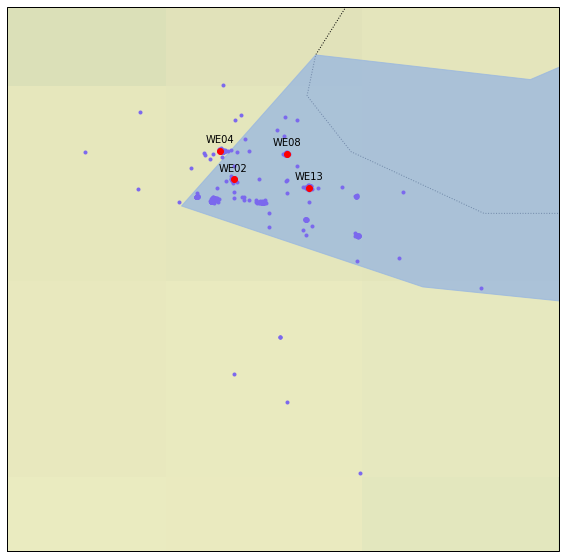

In [241]:
fig = plt.figure(figsize=(20, 10))

# set up map
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

# define map boundaries by lon, lat
ax.set_extent([min(NOAA_full_dat['longitude (decimal deg)']) - 0.2,
               max(NOAA_full_dat['longitude (decimal deg)']) + 0.2, 
               max(NOAA_full_dat['latitude (decimal deg)']) + 0.2, 
               min(NOAA_full_dat['latitude (decimal deg)']) - 0.2], 
              crs = ccrs.PlateCarree()
             )

# add features to the map
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.75)
ax.add_feature(cfeature.RIVERS)

# overlay map image
ax.stock_img()

# plot points for boat observations
ax.plot(boat_unique_coords['longitude (decimal deg)'].to_numpy().tolist(), 
        boat_unique_coords['latitude (decimal deg)'].to_numpy().tolist(),
        color='mediumslateblue', marker='.', ls='',
        transform=ccrs.Geodetic(),
        )

# add points for the stations!
ax.plot(station_coords['lon'].to_numpy().tolist(), 
        station_coords['lat'].to_numpy().tolist(),
        color='red', marker='o', ls='',
        transform=ccrs.Geodetic(),
        )

# include text for station names
for i in range(0, station_coords.shape[0]): 
    ax.text(station_coords.iloc[i,]['lon'], 
            station_coords.iloc[i,]['lat'] + 0.02,
            s = station_coords.iloc[i,]['station'],
            ha = 'center',
            transform=ccrs.Geodetic()
           )

plt.show()

There appears to be some observations that are outside of the lake? Will have to double check, starting with the westernmost and southernmost observations. **Note: rivers don't appear on large scale maps!**

In [262]:
boat_unique_coords.iloc[
    boat_unique_coords['longitude (decimal deg)'].nsmallest(keep = 'all').index]

boat_unique_coords.iloc[
    boat_unique_coords['latitude (decimal deg)'].nsmallest(keep = 'all').index]

,station,latitude (decimal deg),longitude (decimal deg),size
0,Small_boat_2012_2018,41.0127,-83.0055,1
1,Small_boat_2012_2018,41.1941,-83.1941,1
2,Small_boat_2012_2018,41.2633,-83.3290,3
3,Small_boat_2012_2018,41.3587,-83.2117,1
4,Small_boat_2012_2018,41.3591,-83.2107,1


In [265]:
NOAA_full_dat.iloc[
    NOAA_full_dat['latitude (decimal deg)'].nsmallest(keep = 'all').index
]

,timestamp (UTC),wave_height (meter),wave_direction (degrees),wave_period (seconds),wind_speed (meters per second),wind_direction (degrees),water_temperature (degrees Celsius),conductivity (micorosiemens per centimeter),specific_conductivity (micorosiemens per centimeter),total_dissolved_solids (milligrams per liter),ph,ph_mv (millivolts),oxidation_reduction_potential (millivolts),flourescent_dissolved_organic_matter (RFU),flourescent_dissolved_organic_matter_qsu (quinine sulfate units),turbidity (FNU),chlorophylla_rfu (RFU),chlorophylla (micrograms per liter),phycocyanin_rfu (RFU),phycocyanin (micrograms per liter),organic_dissolved_oxygen_saturation (%),organic_dissolved_oxygen (milligrams per liter),depth (meter),turbidity_c6 (NTU),phycoerythrin_c6 (RFU),phycocyanin_c6 (RFU),chlorophylla_c6 (RFU),colored_dissolved_organic_matter_c6 (ppb),depth_c6 (meter),water_temperature_c6 (degrees Celsius),station,longitude (decimal deg),latitude (decimal deg),site,phosphate (micrograms per liter),phosphate_flags,run_number,run_number_flags,wind_speed_max (meters per second),wind_speed_max_flags,wind_speed_mean (meters per second),wind_speed_mean_flags,wind_direction_mean (degrees),wind_direction_mean_flags,air_temp (degrees Celsius),air_temp_flags,barometric_pressure (mbar),barometric_pressure_flags,depth (meters),depth_flags,water_temperature_flags,specific_conductivity (millisiemens per centimeter),specific_conductivity_flags,ph (pH),ph_flags,turbidity (NTU),turbidity_flags,organic_dissolved_oxygen_saturation_flags,organic_dissolved_oxygen_flags,chlorophylla (RFU),chlorophylla_flags,phycocyanin (RFU),phycocyanin_flags,flourescent_dissolved_organic_matter_flags,turbidty_c6_flags,phycoerythrin_c6_flags,phycocyanin_c6_flags,chlorophylla_c6_flags,colored_dissolved_organic_matter_c6_flags,depth_c6 (meters),depth_c6_flags,water_temp_c6 (degrees Celsius),water_temp_c6_flags,no3m_suna (micromoles per liter),no3m_suna_flags,no3_suna (milligrams per liter),no3_suna_flags,turbidity_c6_flags,water_temperature_c6_flags,date,station depth (m),sample depth (m),sample depth (category),local time (eastern time zone),wind speed (knots),wave height (ft),sky,secchi depth (m),sample temperature (°c),ctd temperature (°c),ctd specific conductivity (µs/cm),ctd beam attenuation (m-1),ctd tramission (%),ctd dissolved oxygen (mg/l),ctd photosynthetically active radiation (µe/m2/s),turbidity (ntu),particulate microcystin (µg/l),dissolved microcystin (µg/l),extracted phycocyanin (µg/l),extracted chlorophyll a (µg/l),total phosphorus (µg p/l),total dissolved phosphorus (µg p/l),soluble reactive phosphorus (µg p/l),ammonia (µg n/l),nitrate + nitrite (mg n/l),urea (µg n/l),particulate organic carbon (mg/l),particulate organic nitrogen (mg/l),dissolved organic carbon (mg/l),colored dissolved organic material absorbance (m-1) at 400nm,total suspended solids (mg/l),volatile suspended solids (mg/l)
277619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Small_boat_2012_2018,-83.0055,41.0127,WE2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/15/2012,5.10,0.75,Surface,10:40,NaN,NaN,sunny,1.8,17.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<0.1,NaN,0.28,3.67,16.21,NaN,3.23,10.22,0.459,NaN,NaN,NaN,2.88,NaN,3.47,1.11
278083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Small_boat_2012_2018,-83.1941,41.1941,WE4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9/8/2015,8.37,0.75,Surface,13:18,2.62,0.46,sunny,0.4,NaN,25.6,239.8,3.9,37.6,9.4,570.0,9.24,1.17,0.08,41.16,48.64,42.13,14.88,1.92,0.64,<0.002,NaN,3.28,0.52,3.52,0.800,9.20,6.34
278663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

On Google Maps, these coordinates seem to be on land. 

In [13]:
import pip
from pip._internal.utils.misc import get_installed_distributions
# [lib for lib in get_installed_distributions() if 'map' in lib]

get_installed_distributions()

[yfinance 0.1.54 (c:\users\angela\appdata\roaming\python\python37\site-packages),
 multitasking 0.0.9 (c:\users\angela\appdata\roaming\python\python37\site-packages),
 matplotlib 3.3.2 (c:\users\angela\appdata\roaming\python\python37\site-packages),
 certifi 2020.6.20 (c:\users\angela\appdata\roaming\python\python37\site-packages),
 -illow 5.4.1 (c:\users\angela\documents\wpy64-3720\python-3.7.2.amd64\lib\site-packages),
 -atplotlib 3.0.3 (c:\users\angela\documents\wpy64-3720\python-3.7.2.amd64\lib\site-packages),
 zope.interface 5.1.2 (c:\users\angela\documents\wpy64-3720\python-3.7.2.amd64\lib\site-packages),
 zope.event 4.5.0 (c:\users\angela\documents\wpy64-3720\python-3.7.2.amd64\lib\site-packages),
 zict 0.1.3 (c:\users\angela\documents\wpy64-3720\python-3.7.2.amd64\lib\site-packages),
 zarr 2.2.0 (c:\users\angela\documents\wpy64-3720\python-3.7.2.amd64\lib\site-packages),
 xlwings 0.15.3 (c:\users\angela\documents\wpy64-3720\python-3.7.2.amd64\lib\site-packages),
 XlsxWriter 1.1

### Water Temperature

In [282]:
print('There are {} observation pairs for water temperature (degrees Celsius) and chlorophyll a (RFU).'.format(
 sum(NOAA_full_dat['water_temperature (degrees Celsius)'].notnull() & NOAA_full_dat['water_temperature (degrees Celsius)'].notnull())))

There are 215715 observation pairs for water temperature (degrees Celsius) and chlorophyll a (RFU).


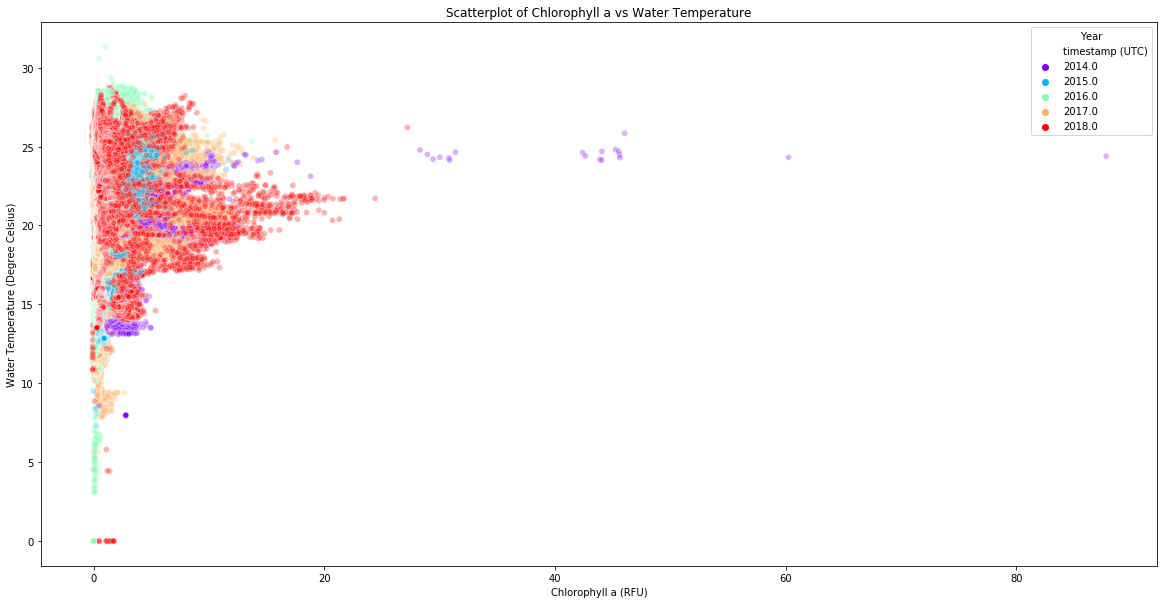

In [27]:
# Look at scatterplot of chlorophyll a vs water temperature 
# with colour grouping by year

fig, ax = plt.subplots(figsize=(20, 10))

sns.scatterplot(x = NOAA_full_dat['chlorophylla (RFU)'], 
                y = NOAA_full_dat['water_temperature (degrees Celsius)'], 
                hue = NOAA_full_dat['timestamp (UTC)'].dt.year, 
                legend = 'full',
                palette = 'rainbow', 
                alpha = 0.3).legend().set_title('Year')

# plt.legend(title='Timestamp - Month', loc='lower right')
# chlor_wat_temp_plot._legend.set_title('Timestamp Month')

plt.title('Scatterplot of Chlorophyll a vs Water Temperature')
plt.xlabel('Chlorophyll a (RFU)')
plt.ylabel('Water Temperature (Degree Celsius)')
plt.show()

The majority of observations across the range of water temperature have `chlorophylla (RFU)` less than 20 RFU. The year 2014 has particularly high chlorophyll a measurements. 2018 also seems to have more observations with water temperatures in the 15 to 30 degrees Celsius range; this may be an issue with the data in that there are fewer `NaN` values for the variables `chlorophylla (RFU)` and `water_temperature (degrees Celsius)` in 2018. There seems to be more cooler observations in 2016.

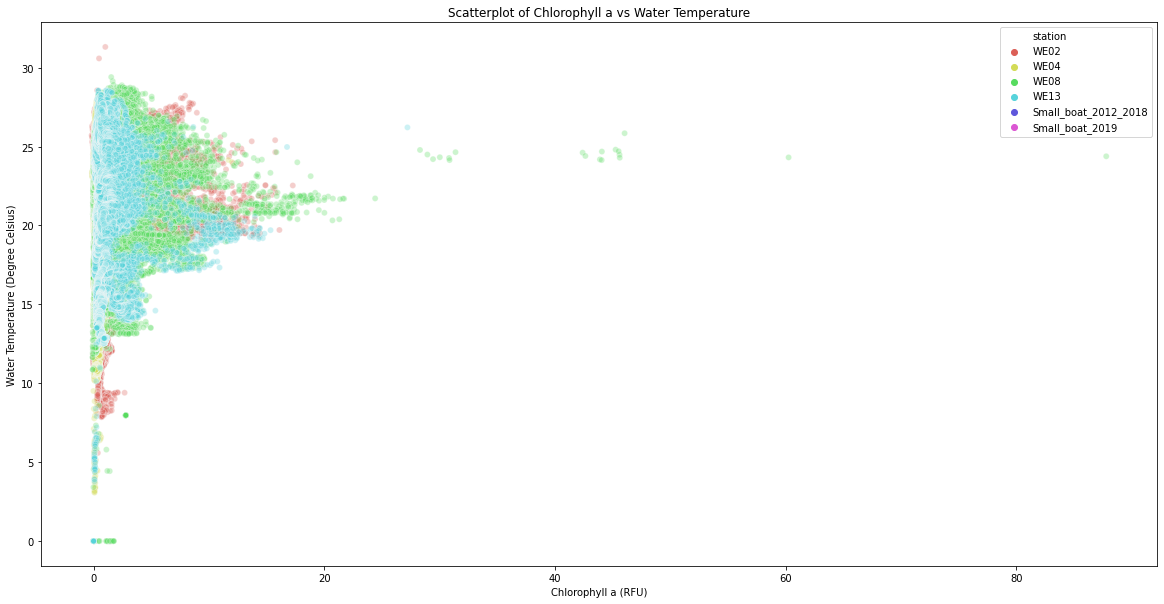

In [313]:
# Look at scatterplot of chlorophyll a vs water temperature 
# with colour grouping by station

fig, ax = plt.subplots(figsize=(20, 10))

sns.scatterplot(x = NOAA_full_dat['chlorophylla (RFU)'], 
                y = NOAA_full_dat['water_temperature (degrees Celsius)'], 
                hue = NOAA_full_dat['station'], 
                legend = 'full',
                palette = sns.color_palette('hls', len(NOAA_full_dat['station'].unique())), 
                alpha = 0.3)

plt.title('Scatterplot of Chlorophyll a vs Water Temperature')
plt.xlabel('Chlorophyll a (RFU)')
plt.ylabel('Water Temperature (Degree Celsius)')
plt.show()

Most of the observations with high chlorophyll a readings are from station WE08. 

### Dissolved Oxygen

Used `organic_dissolved_oxygen (milligrams per liter)` for the EDA. 

In [29]:
print('There are {} observation pairs for organic dissolved oxygen (milligrams per liter) and chlorophyll a (RFU).'.format(
 sum(NOAA_full_dat['water_temperature (degrees Celsius)'].notnull() & NOAA_full_dat['organic_dissolved_oxygen (milligrams per liter)'].notnull())))

[var for var in NOAA_full_dat.columns if 'oxy' in var]

There are 209222 observation pairs for organic dissolved oxygen (milligrams per liter) and chlorophyll a (RFU)


['organic_dissolved_oxygen_saturation (%)',
 'organic_dissolved_oxygen (milligrams per liter)',
 'organic_dissolved_oxygen_saturation_flags',
 'organic_dissolved_oxygen_flags',
 'ctd dissolved oxygen (mg/l)']

In [34]:
NOAA_full_dat.loc[NOAA_full_dat['timestamp (UTC)'].dt.year == 2018.0,'organic_dissolved_oxygen (milligrams per liter)'].describe()

count    56386.000000
mean         9.492664
std          1.620789
min          6.527000
25%          8.520000
50%          9.180000
75%          9.980000
max         21.170000
Name: organic_dissolved_oxygen (milligrams per liter), dtype: float64

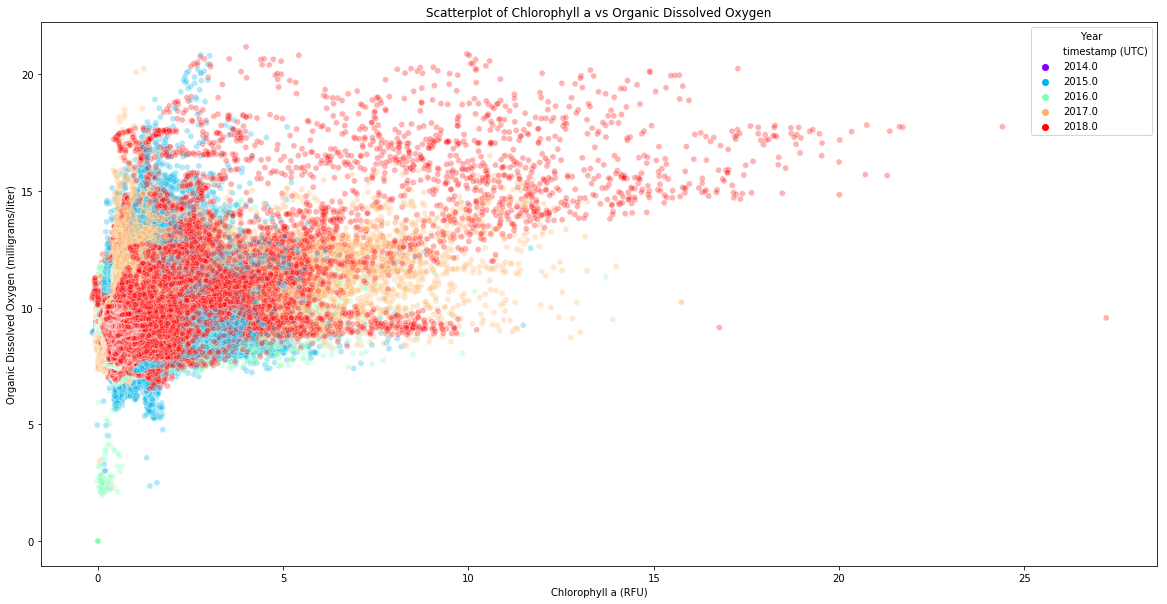

In [24]:
# Look at scatterplot of chlorophyll a vs dissolved oxygen concentration 
# with colour grouping by year

fig, ax = plt.subplots(figsize=(20, 10))

sns.scatterplot(x = NOAA_full_dat['chlorophylla (RFU)'], 
                y = NOAA_full_dat['organic_dissolved_oxygen (milligrams per liter)'], 
                hue = NOAA_full_dat['timestamp (UTC)'].dt.year, 
                legend = 'full',
                palette = 'rainbow', 
                alpha = 0.3).legend().set_title('Year')

plt.title('Scatterplot of Chlorophyll a vs Organic Dissolved Oxygen')
plt.xlabel('Chlorophyll a (RFU)')
plt.ylabel('Organic Dissolved Oxygen (milligrams/liter)')
plt.show()

Low dissolved oxygen is usually a consequence of algal growth! From [Science Daily](https://www.sciencedaily.com/terms/algal_bloom.htm): 

>"Some algal blooms are the result of an excess of nutrients (particularly phosphorus and nitrogen) into waters and higher concentrations of these nutrients in water cause increased growth of algae and green plants.   
As more algae and plants grow, others die.   
This dead organic matter becomes food for bacteria that decompose it.  
With more food available, the bacteria increase in number and use up the dissolved oxygen in the water."

Interesting that observations with the highest chlorophyll a readings have higher organic dissolved oxygen. Water temperature and organic dissolve oxygen concentrations are inversely related, so it may be helpful to see a scatterplot of the above but with months as the colour groupings instead of years. 

We also note there are roughly 6500 fewer observation pairs of (chlorophyll a (RFU), organic_dissolved_oxygen (milligrams per liter)) than (chlorophyll a (RFU), water_temperature (degrees Celsius)).

In [35]:
NOAA_full_dat['timestamp (UTC)'].dt.month.describe()

count    277608.000000
mean          7.828373
std           1.484466
min           4.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          11.000000
Name: timestamp (UTC), dtype: float64

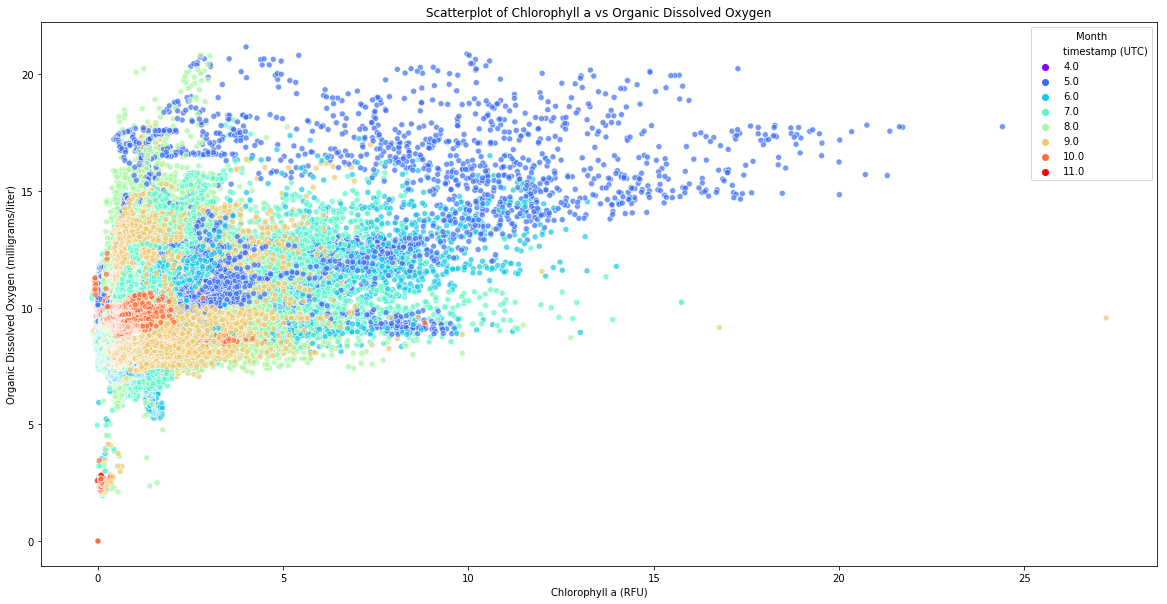

In [25]:
# Look at scatterplot of chlorophyll a vs dissolved oxygen
# with colour grouping by month

fig, ax = plt.subplots(figsize=(20, 10))

sns.scatterplot(x = NOAA_full_dat['chlorophylla (RFU)'], 
                y = NOAA_full_dat['organic_dissolved_oxygen (milligrams per liter)'], 
                hue = NOAA_full_dat['timestamp (UTC)'].dt.month, 
                legend = 'full',
                palette = 'rainbow', 
                alpha = 0.3).legend().set_title('Month')

plt.title('Scatterplot of Chlorophyll a vs Organic Dissolved Oxygen')
plt.xlabel('Chlorophyll a (RFU)')
plt.ylabel('Organic Dissolved Oxygen (milligrams/liter)')
plt.show()

The scatterplot of chlorophyll a vs organic dissolved oxygen with colour groupings by months show that the observations with notably high chlorophyll a readings are from May. Coupling the scatterplot with colour groupings by year above and this scatterplot with colour groupings by month shows that May 2018 had particularly high chlorophyll a observations. Important to note that we cannot view this univariate relationship in a vacuum - there may have been external factors that cause readings to be so elevated!

### pH

Used `ph (pH scale)` for the EDA. 

In [323]:
print('Summary of ph (ph scale) observations: \n{}\n'.format(
    NOAA_full_dat['ph (ph scale)'].describe()))
print('Summary of ph (ph scale) for observations with chlorophylla (RFU) > 11:\n{}\n'.format(
    NOAA_full_dat.loc[NOAA_full_dat['ph (ph scale)'] > 11, 'ph (ph scale)'].describe()))
print('Summary of ph (ph scale) for observations with chlorophylla (RFU) < 7:\n{}'.format(
    NOAA_full_dat.loc[NOAA_full_dat['ph (ph scale)'] < 7, 'ph (ph scale)'].describe()))

Summary of ph (ph scale) observations: 
count    207864.000000
mean          8.433560
std           1.240364
min           0.000000
25%           8.270000
50%           8.530000
75%           8.850000
max          17.900000
Name: ph (ph scale), dtype: float64

Summary of ph (ph scale) for observations with chlorophylla (RFU) > 11:
count    98.000000
mean     17.817959
std       0.325858
min      14.970000
25%      17.870000
50%      17.870000
75%      17.870000
max      17.900000
Name: ph (ph scale), dtype: float64

Summary of ph (ph scale) for observations with chlorophylla (RFU) < 7:
count    3874.000000
mean        0.100261
std         0.564056
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.975000
Name: ph (ph scale), dtype: float64


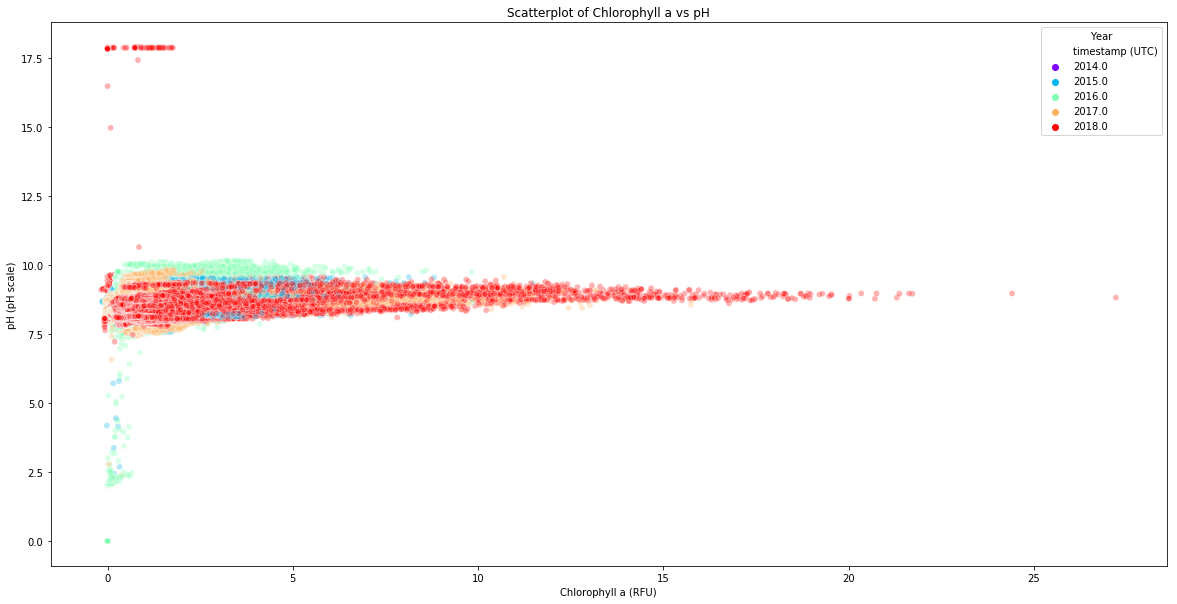

In [85]:
# Look at scatterplot of chlorophyll a vs pH
# with colour grouping by year

fig, ax = plt.subplots(figsize=(20, 10))

sns.scatterplot(x = NOAA_full_dat['chlorophylla (RFU)'], 
                y = NOAA_full_dat['ph (ph scale)'], 
                hue = NOAA_full_dat['timestamp (UTC)'].dt.year, 
                legend = 'full',
                palette = 'rainbow', 
                alpha = 0.3).legend().set_title('Year')

plt.title('Scatterplot of Chlorophyll a vs pH')
plt.xlabel('Chlorophyll a (RFU)')
plt.ylabel('pH (pH scale)')
plt.show()

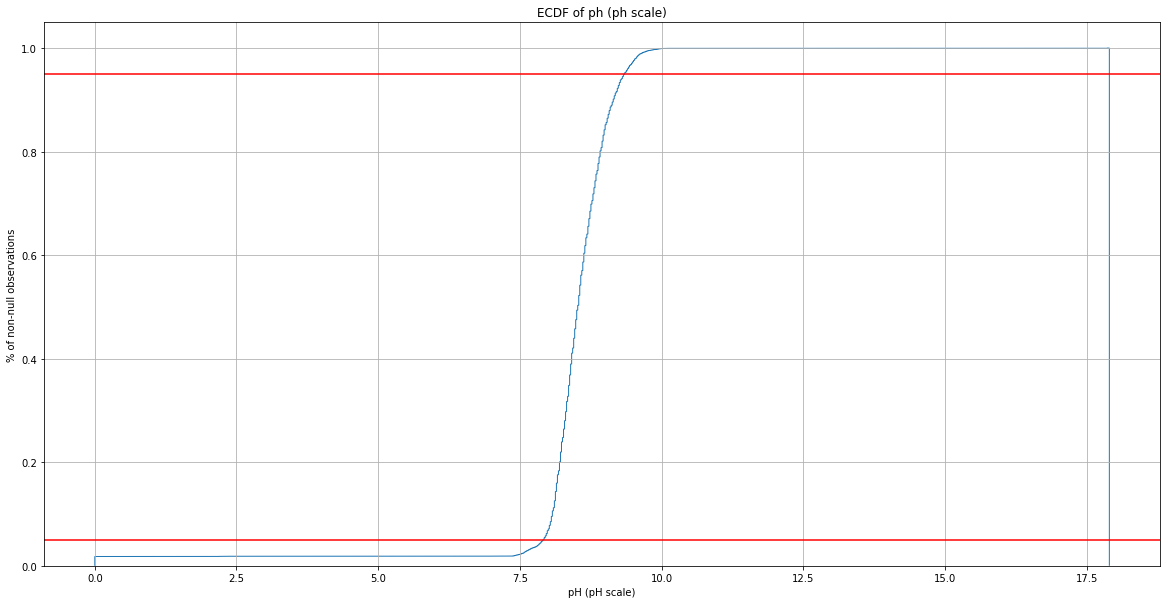

0.05    7.92
0.10    8.08
0.90    9.16
0.95    9.35
Name: ph (ph scale), dtype: float64


In [100]:
fig, ax = plt.subplots(figsize=(20, 10))

# plot ECDF of ph (ph scale)
NOAA_full_dat['ph (ph scale)'].hist(cumulative=True, density=1, bins=1000, histtype='step')
plt.title('ECDF of ph (ph scale)')
plt.xlabel('pH (pH scale)')
plt.ylabel('% of non-null observations')

# add lines denoting 5th, 95th percentile
plt.axhline(y=0.05, color = 'r') 
plt.axhline(y=0.95, color = 'r') 

plt.show()

print(NOAA_full_dat['ph (ph scale)'].quantile([0.05, 0.1, 0.9, 0.95]))

In [328]:
print(NOAA_full_dat['ph (ph scale)'].quantile([0.02, 0.98]))

0.02    7.429
0.98    9.550
Name: ph (ph scale), dtype: float64


Observations with higher chlorophyll a readings have higher-than-median pH readings. According to the [North Carolina Environmental Quality](https://deq.nc.gov/about/divisions/water-resources/water-resources-data/water-sciences-home-page/ecosystems-branch/algal-blooms), "high pH (greater than 8.0) can be an indicator of photosynthesis by large quantities of algae" as algae photosynthesis raise hydroxide levels in the water. 90% of the non-null observations for `ph (ph scale)` lie between 7.92 and 9.35, so pH may not be a strong predictor as the majority of observations have pH within these bounds. 

### Phosphorus 

In [15]:
NOAA_full_dat.loc[NOAA_full_dat['chlorophylla (RFU)'].notnull() &
                 NOAA_full_dat['phosphate (micrograms per liter)'].notnull()]

,timestamp (UTC),wave_height (meter),wave_direction (degrees),wave_period (seconds),wind_speed (meters per second),wind_direction (degrees),water_temperature (degrees Celsius),conductivity (micorosiemens per centimeter),specific_conductivity (micorosiemens per centimeter),total_dissolved_solids (milligrams per liter),ph,ph_mv (millivolts),oxidation_reduction_potential (millivolts),flourescent_dissolved_organic_matter (RFU),flourescent_dissolved_organic_matter_qsu (quinine sulfate units),turbidity (FNU),chlorophylla_rfu (RFU),chlorophylla (micrograms per liter),phycocyanin_rfu (RFU),phycocyanin (micrograms per liter),organic_dissolved_oxygen_saturation (%),organic_dissolved_oxygen (milligrams per liter),depth (meter),turbidity_c6 (NTU),phycoerythrin_c6 (RFU),phycocyanin_c6 (RFU),chlorophylla_c6 (RFU),colored_dissolved_organic_matter_c6 (ppb),depth_c6 (meter),water_temperature_c6 (degrees Celsius),station,longitude (decimal deg),latitude (decimal deg),site,phosphate (micrograms per liter),phosphate_flags,run_number,run_number_flags,wind_speed_max (meters per second),wind_speed_max_flags,wind_speed_mean (meters per second),wind_speed_mean_flags,wind_direction_mean (degrees),wind_direction_mean_flags,air_temp (degrees Celsius),air_temp_flags,barometric_pressure (mbar),barometric_pressure_flags,depth (meters),depth_flags,water_temperature_flags,specific_conductivity (millisiemens per centimeter),specific_conductivity_flags,ph (pH),ph_flags,turbidity (NTU),turbidity_flags,organic_dissolved_oxygen_saturation_flags,organic_dissolved_oxygen_flags,chlorophylla (RFU),chlorophylla_flags,phycocyanin (RFU),phycocyanin_flags,flourescent_dissolved_organic_matter_flags,turbidty_c6_flags,phycoerythrin_c6_flags,phycocyanin_c6_flags,chlorophylla_c6_flags,colored_dissolved_organic_matter_c6_flags,depth_c6 (meters),depth_c6_flags,water_temp_c6 (degrees Celsius),water_temp_c6_flags,no3m_suna (micromoles per liter),no3m_suna_flags,no3_suna (milligrams per liter),no3_suna_flags,turbidity_c6_flags,water_temperature_c6_flags,date,station depth (m),sample depth (m),sample depth (category),local time (eastern time zone),wind speed (knots),wave height (ft),sky,secchi depth (m),sample temperature (°c),ctd temperature (°c),ctd specific conductivity (µs/cm),ctd beam attenuation (m-1),ctd tramission (%),ctd dissolved oxygen (mg/l),ctd photosynthetically active radiation (µe/m2/s),turbidity (ntu),particulate microcystin (µg/l),dissolved microcystin (µg/l),extracted phycocyanin (µg/l),extracted chlorophyll a (µg/l),total phosphorus (µg p/l),total dissolved phosphorus (µg p/l),soluble reactive phosphorus (µg p/l),ammonia (µg n/l),nitrate + nitrite (mg n/l),urea (µg n/l),particulate organic carbon (mg/l),particulate organic nitrogen (mg/l),dissolved organic carbon (mg/l),colored dissolved organic material absorbance (m-1) at 400nm,total suspended solids (mg/l),volatile suspended solids (mg/l)


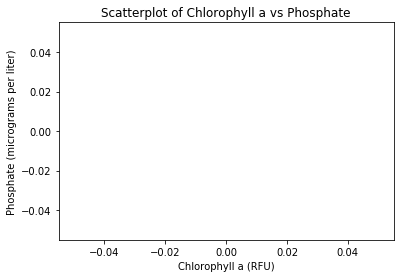

In [14]:
# Remember, phosphate timestamp DO NOT align with the rest of the observations in the WE__ data sets
# because phosphate records are found in a separate file!

fig, ax = plt.subplots()

sns.scatterplot(x = NOAA_full_dat['chlorophylla (RFU)'], 
                y = NOAA_full_dat['phosphate (micrograms per liter)'], 
                hue = NOAA_full_dat['timestamp (UTC)'].dt.year, 
                legend = 'full',
                palette = 'rainbow', 
                alpha = 0.3)

plt.title('Scatterplot of Chlorophyll a vs Phosphate')
plt.xlabel('Chlorophyll a (RFU)')
plt.ylabel('Phosphate (micrograms per liter)')
plt.show()

# Scrap Code/Notes

Is this the device used to take measurements? https://waterwatch.usgs.gov/wqwatch/faq?faq_id=5

In [ ]:
dirList = os.listdir(noaa_dir)
print(dirList)

[os.path.isdir(path) for path in
 [os.path.join(noaa_dir, direct) for direct in dirList]]

# Check for differences and similarities in the WE04 2015 and 2016 data sets
set(NOAA_sets['WE04_2015_annual_summary'].columns).symmetric_difference(set(NOAA_sets['WE04_2016_annual_summary'].columns))
len(set(NOAA_sets['WE04_2015_annual_summary'].columns).intersection(set(NOAA_sets['WE04_2016_annual_summary'].columns)))

# Set up wrapper function for fuzzy matching 
# Inputs are vector of strings and minimum Levenshtein distance to group similar strings
def fuzz_set_ratio(strings, min_lev_ratio):
    return map(lambda ratio: ratio < min_lev_ratio, map(lambda name: fuzz.token_set_ratio(strings, name), lev_arr))

# To get variable names for which Lev ratio is greater than threshold value
[NOAA_orig_vars[i] for i in [index for index, value in enumerate(tst_lev_dist) if value > 50]]